In [1]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import numpy as np
import pandas as pd
import scanpy as sc
from scipy import stats, linalg
from sklearn.decomposition import PCA

class CfRNARigorousGeometry:
    def __init__(self, adata, pheno_col='Responder', bias_dict=None, n_stable_genes=2000):
        self.adata = adata.copy()
        self.pheno_col = pheno_col
        
        if np.max(self.adata.X) > 20: 
            print("⚠️ Warning: Data values seem too high. Is it log1p transformed?")
        
        self.bias_dict = bias_dict if bias_dict else {
            'Platelet': 'platelet_score', 'Length': 'len_bias_score', 'GC': 'gc_bias_score'
        }
        self.valid_biases = {k: v for k, v in self.bias_dict.items() if v in self.adata.obs.columns}
        print(f"🧬 Selecting {n_stable_genes} stable genes (Detection > 50% & High Mean)...")
        X = self.adata.X
        mean_counts = np.array(X.mean(axis=0)).flatten()
        if hasattr(X, "todense"):
            detected = np.array((X > 0).mean(axis=0)).flatten()
        else:
            detected = np.array((X > 0).mean(axis=0)).flatten()
        mask_detect = detected > 0.5
        candidates = self.adata.var_names[mask_detect]
        sorted_genes = self.adata.var.loc[candidates].copy()
        sorted_genes['mean'] = mean_counts[mask_detect]
        
        # Check if we have enough candidates
        if len(candidates) < n_stable_genes:
            print(f"⚠️ Warning: Only {len(candidates)} genes met detection criteria. Using all.")
            top_genes = sorted_genes.index
        else:
            top_genes = sorted_genes.nlargest(n_stable_genes, 'mean').index
        
        self.adata = self.adata[:, top_genes].copy()
        print(f"   -> Final Gene Set Size: {self.adata.n_vars}")

    def _get_bias_col(self, key_or_col):
        if key_or_col in self.valid_biases.values():
            return key_or_col
        return self.valid_biases.get(key_or_col, key_or_col)

    def _safe_dense(self, X):
        if hasattr(X, "toarray"): return X.toarray()
        elif hasattr(X, "todense"): return np.asarray(X.todense())
        return np.asarray(X)

    def _align_vectors(self, vec_target, vec_ref):
        if np.dot(vec_target, vec_ref) < 0:
            return -vec_target
        return vec_target
    
    def _fail_plot(self, ax, message):
        """Helper to print error on plot instead of crashing"""
        if ax is not None:
            ax.text(0.5, 0.5, message, ha='center', va='center', transform=ax.transAxes, color='red')
            ax.set_axis_off()

    # =========================================================================
    # Figure Generators (Now accepting 'ax' argument)
    # =========================================================================
    def figure1_geometry_deformation(self, bias_col, axes_list=None):
        """ 
        [New Figure 1] Geometry Deformation Analysis (3 Panels)
        
        - Ax1: Bias Force Field (Quiver) + Statistical Metrics (Legend)
        - Ax2: Centroid Migration (Geometry Shift)
        - Ax3: Covariance Trajectory (Original Logic preserved)
        """
        if axes_list is None: return
        ax1, ax2, ax3 = axes_list
        
        # 공통 데이터 준비
        X = self._safe_dense(self.adata.X)
        X_centered = X - X.mean(axis=0)
        bias_vals = self.adata.obs[bias_col].values
        
        # PCA 수행 (Global Geometry for Ax1, Ax2)
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X_centered)
        
        # 1. Force Vector Calculation
        b_norm = (bias_vals - bias_vals.mean()) / (bias_vals.std() + 1e-9)
        vec_bias_gene = np.dot(X_centered.T, b_norm) / (X.shape[0] - 1)
        vec_bias_pca = pca.transform(vec_bias_gene.reshape(1, -1))[0]
        
        # 2. Scatter Plot (Background)
        ax1.scatter(X_pca[:, 0], X_pca[:, 1], c=bias_vals, cmap='coolwarm', s=15, alpha=0.6)
        
        # 3. Arrow Drawing (Force Direction)
        origin = np.mean(X_pca, axis=0)
        scale = np.max(np.abs(X_pca)) * 0.5
        vec_len = np.linalg.norm(vec_bias_pca)
        v_scaled = (vec_bias_pca / vec_len) * scale
        
        ax1.arrow(origin[0], origin[1], v_scaled[0], v_scaled[1], 
                  head_width=scale*0.1, width=scale*0.015, color='black', zorder=10)
        
        # 4. Metrics Legend (요청하신 부분: 통계 수치를 그래프 안으로)
        pc1_corr = np.corrcoef(X_pca[:, 0], bias_vals)[0, 1]
        var_expl = pca.explained_variance_ratio_[0] * (pc1_corr**2) * 100
        
        stats_text = (f"Bias Dominance:\n"
                      f"• PC1 Corr: {pc1_corr:.2f}\n"
                      f"• Bias Var: {var_expl:.1f}%")
        
        props = dict(boxstyle='round', facecolor='white', alpha=0.9)
        ax1.text(0.05, 0.95, stats_text, transform=ax1.transAxes, va='top', ha='left',
                 fontsize=10, fontweight='bold', bbox=props)
        ax1.set_title(f"1. Force Field (Direction)")
        ax1.set_xlabel("PC1"); ax1.set_ylabel("PC2")

        n_bins = 5
        bins = np.linspace(bias_vals.min(), bias_vals.max(), n_bins+1)
        centroids = []
        bin_colors = []
        
        for i in range(n_bins):
            mask = (bias_vals >= bins[i]) & (bias_vals < bins[i+1])
            if np.sum(mask) > 5:
                centroids.append(np.mean(X_pca[mask], axis=0))
                bin_colors.append(np.mean(bias_vals[mask]))
        centroids = np.array(centroids)
        
        # Background
        ax2.scatter(X_pca[:, 0], X_pca[:, 1], c='lightgrey', s=10, alpha=0.3)
        
        # Trajectory
        if len(centroids) > 1:
            ax2.plot(centroids[:, 0], centroids[:, 1], 'k--', lw=2, zorder=5)
            ax2.scatter(centroids[:, 0], centroids[:, 1], c=bin_colors, cmap='coolwarm', 
                        s=150, edgecolor='black', marker='D', zorder=10)
            ax2.text(centroids[0, 0], centroids[0, 1], " Low", fontweight='bold', ha='left')
            ax2.text(centroids[-1, 0], centroids[-1, 1], " High", fontweight='bold', ha='right')

        ax2.set_title("2. Centroid Migration (Shift)")
        ax2.set_xlabel("PC1"); ax2.set_yticks([])

        # =========================================================
        # [Ax3] Covariance Trajectory (Rotation)
        # =========================================================
        sorted_idx = np.argsort(self.adata.obs[bias_col].values)
        X_sorted = self._safe_dense(self.adata.X[sorted_idx, :])
        bias_sorted = self.adata.obs[bias_col].values[sorted_idx]
        
        n_samples = X_sorted.shape[0]
        window_size = 50
        stride = 10
        
        # Adaptive window logic
        if n_samples < window_size:
            if n_samples >= 20:
                window_size = int(n_samples / 2)
                stride = max(1, int(window_size / 5))
            else:
                self._fail_plot(ax3, f"N={n_samples} < 20 (Too small)")
                return

        eigen_states, bias_means = [], []
        end_point = n_samples - window_size + 1
        
        for i in range(0, end_point, stride):
            window = X_sorted[i : i+window_size, :]
            # Window Z-score (User's original logic)
            std = window.std(axis=0)
            window_z = (window - window.mean(axis=0)) / (std + 1e-9)
            
            w_pca = PCA(n_components=1)
            w_pca.fit(window_z)
            vec = w_pca.components_[0]
            
            if len(eigen_states) > 0:
                vec = self._align_vectors(vec, eigen_states[0])
            
            eigen_states.append(vec)
            bias_means.append(np.mean(bias_sorted[i : i+window_size]))
            
        eigen_states = np.array(eigen_states)
        
        if len(eigen_states) < 3:
            self._fail_plot(ax3, "Not enough windows")
            return

        n_comps = min(2, len(eigen_states), eigen_states.shape[1])
        meta_pca = PCA(n_components=n_comps)
        traj = meta_pca.fit_transform(eigen_states)
        
        # Scatter Plot
        sc_plot = ax3.scatter(traj[:, 0], traj[:, 1] if n_comps==2 else np.zeros_like(traj[:,0]), 
                              c=bias_means, cmap='coolwarm', s=30, edgecolor='k', lw=0.5)
        
        if n_comps == 2:
            ax3.plot(traj[:, 0], traj[:, 1], c='gray', alpha=0.3)
            
        ax3.set_title("3. Covariance Rotation")
        ax3.set_xlabel("Meta-PC1")
        ax3.set_yticks([]) # Clean look
        

    def figure2_conditional_biology(self, bias_col, ax=None):
        """ [Figure 3] Distortion (Cohen's d) """
        if ax is None: return
        
        vals = self.adata.obs[bias_col]
        # Robust quantiles
        sub_low = self.adata[vals <= vals.quantile(0.5)] # Relaxed to 0.5 to ensure samples
        sub_high = self.adata[vals >= vals.quantile(0.5)]
        
        cats = sorted(self.adata.obs[self.pheno_col].unique())
        if len(cats) < 2:
            self._fail_plot(ax, "Need 2 Phenotypes")
            return
        
        # get phenotype effect vectors
        def get_cohens_d(ad):
            X = self._safe_dense(ad.X)
            obs = ad.obs[self.pheno_col]
            g1 = X[obs == cats[1], :]
            g0 = X[obs == cats[0], :]
            
            if g1.shape[0] < 2 or g0.shape[0] < 2: return None
            
            m1, m0 = np.mean(g1, axis=0), np.mean(g0, axis=0)
            v1, v0 = np.var(g1, axis=0, ddof=1), np.var(g0, axis=0, ddof=1)
            s_pooled = np.sqrt(((g1.shape[0]-1)*v1 + (g0.shape[0]-1)*v0) / (g1.shape[0]+g0.shape[0]-2))
            return (m1 - m0) / (s_pooled + 1e-5)

        d_low = get_cohens_d(sub_low)
        d_high = get_cohens_d(sub_high)
        
        if d_low is None or d_high is None:
            self._fail_plot(ax, "Unbalanced Phenotypes in Bins")
            return
            
        if np.std(d_low) == 0 or np.std(d_high) == 0:
            self._fail_plot(ax, "Zero Variance in Effects")
            return

        try:
            res = stats.linregress(d_low, d_high)
        except:
            self._fail_plot(ax, "Regression Failed")
            return
        
        ax.scatter(d_low, d_high, alpha=0.4, s=10, c='purple')
        min_v, max_v = min(d_low.min(), d_high.min()), max(d_low.max(), d_high.max())
        ax.plot([min_v, max_v], [min_v, max_v], 'k--', alpha=0.5) # x=y
        ax.plot([min_v, max_v], res.slope*np.array([min_v, max_v]) + res.intercept, 'r-')
        
        ax.set_title(f"Signal Distortion (Slope={res.slope:.2f})")
        ax.set_xlabel("Effect (Low Bias)")
        ax.set_ylabel("Effect (High Bias)")
        ax.grid(True, alpha=0.3)

    def figure3_eigenvector_rotation(self, bias_col, ax=None):
        """ [Figure 4] Residual Rotation """
        if ax is None: return
        
        adata_resid = self.adata.copy()
        # Handle cases where regress_out might fail if bias is constant
        try:
            sc.pp.regress_out(adata_resid, [bias_col])
            sc.pp.scale(adata_resid, max_value=10)
        except:
            self._fail_plot(ax, "Regress/Scale Failed")
            return
            
        vals = self.adata.obs[bias_col]
        low_grp = adata_resid[vals <= vals.quantile(0.25)]
        high_grp = adata_resid[vals >= vals.quantile(0.75)]
        
        if low_grp.n_obs < 3 or high_grp.n_obs < 3:
            self._fail_plot(ax, "Not enough samples")
            return

        def get_pc1(ad):
            pca = PCA(n_components=1)
            pca.fit(self._safe_dense(ad.X))
            return pca.components_[0]
            
        v_low = get_pc1(low_grp)
        v_high = get_pc1(high_grp)
        v_high = self._align_vectors(v_high, v_low)
        
        sim = np.dot(v_low, v_high) / (np.linalg.norm(v_low) * np.linalg.norm(v_high))
        
        ax.scatter(v_low, v_high, c='black', alpha=0.4, s=15)
        m, b = np.polyfit(v_low, v_high, 1)
        ax.plot(v_low, m*v_low + b, 'r-', alpha=0.6)
        
        ax.set_title(f"Residual Rotation (Sim={sim:.2f})")
        ax.set_xlabel("Low Bias PC1")
        ax.set_ylabel("High Bias PC1")
        ax.grid(True, alpha=0.3)

    def figure4_bias_phenotype_alignment(self, bias_col, ax=None):
        """ [Figure 5] Alignment / Null Model """
        if ax is None: return
        
        X = self._safe_dense(self.adata.X)
        bias_vec = self.adata.obs[bias_col].values
        cats = sorted(self.adata.obs[self.pheno_col].unique())
        if len(cats) < 2:
            self._fail_plot(ax, "Need 2 Phenotypes")
            return
        
        pheno_vec = (self.adata.obs[self.pheno_col] == cats[1]).astype(float).values
        
        def get_corrs(m, t):
            z_m = stats.zscore(m, axis=0)
            z_t = stats.zscore(t)
            # Handle NaN from zscore if const
            z_m = np.nan_to_num(z_m)
            z_t = np.nan_to_num(z_t)
            return np.dot(z_m.T, z_t) / m.shape[0]

        obs_bias = get_corrs(X, bias_vec)
        obs_pheno = get_corrs(X, pheno_vec)
        
        # Null Model (Fast: 20 permutations)
        null_pheno = []
        for _ in range(20):
            null_pheno.append(get_corrs(X, np.random.permutation(pheno_vec)))
        null_pheno = np.array(null_pheno).flatten()
        null_bias = np.tile(obs_bias, 20)
        
        # Plot
        sns.kdeplot(x=null_bias, y=null_pheno, ax=ax, fill=True, color='gray', alpha=0.2, levels=3)
        ax.scatter(obs_bias, obs_pheno, c='red', s=10, alpha=0.5)
        
        # Fit
        try:
            m, b = np.polyfit(obs_bias, obs_pheno, 1)
            ax.plot(obs_bias, m*obs_bias + b, 'r-', lw=1.5)
        except: pass
        
        ax.axhline(0, c='k', lw=0.5, ls='--'); ax.axvline(0, c='k', lw=0.5, ls='--')
        ax.set_title("Bias-Phenotype Alignment")
        ax.set_xlabel(f"Corr w/ Bias")
        ax.set_ylabel("Corr w/ Pheno")
        
    def run_all(self, target_bias='Platelet'):
        """
        Full 2x3 Dashboard:
        [ Row 1 ] Geometry Proof: Force Field | Centroid Shift | Covariance Trajectory
        [ Row 2 ] Biological Impact: Signal Distortion | Eigenvector Rotation | Alignment
        """
        bias_col = self._get_bias_col(target_bias)
        display_name = [k for k, v in self.valid_biases.items() if v == bias_col]
        display_name = display_name[0] if display_name else target_bias
        
        print(f"🚀 Generating Full Geometry & Impact Dashboard for: {display_name} ...")
        
        # Grid 설정: 2행 3열
        fig = plt.figure(figsize=(17, 10))
        gs = gridspec.GridSpec(2, 3, height_ratios=[1, 1])
        
        # --- Row 1: Geometry (물리적 변형) ---
        ax1 = fig.add_subplot(gs[0, 0])
        ax2 = fig.add_subplot(gs[0, 1])
        ax3 = fig.add_subplot(gs[0, 2])
        
        # --- Row 2: Impact (생물학적 왜곡) ---
        ax4 = fig.add_subplot(gs[1, 0])
        ax5 = fig.add_subplot(gs[1, 1])
        ax6 = fig.add_subplot(gs[1, 2])
        
        # 1. Geometry Proof (상단 3개: Force, Shift, Trajectory)
        self.figure1_geometry_deformation(bias_col, axes_list=[ax1, ax2, ax3])
        
        # 2. Biological Impact (하단 3개: Distortion, Rotation, Alignment)
        self.figure2_conditional_biology(bias_col, ax=ax4)
        self.figure3_eigenvector_rotation(bias_col, ax=ax5)
        self.figure4_bias_phenotype_alignment(bias_col, ax=ax6)
        
        # 제목 설정
        fig.suptitle(f"Bias Geometry & Biological Impact Analysis: {display_name}", 
                     fontsize=16, fontweight='bold', y=0.98)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

### Load Adata

In [3]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from scipy.stats import spearmanr
from statsmodels.nonparametric.smoothers_lowess import lowess

matplotlib.rcParams['font.family'] = 'Arial'
plt.style.use('seaborn-v0_8-talk')

annot = pd.read_table("/project/cfRNA_Disentaglement/Data/GECODEv49_Annot.tsv", index_col=0)
palangodb = pd.read_table("./Data/PalangoDB_CellTypeMarkers.tsv")

meta = pd.read_csv("/project/cfRNA_Disentaglement/Data/RPM/RPM_Lab/Meta.csv", index_col=0)
counts = pd.read_csv("/project/cfRNA_Disentaglement/Data/RPM/RPM_Lab/RPM10_12_13_14_16_raw.csv", index_col=0)
counts_seq15 = pd.read_csv("/project/cfRNA_Disentaglement/Data/RPM/Compgen_Lab/Seq15.csv", index_col=0).astype(int)
counts = pd.merge(counts, counts_seq15, left_index=True, right_index=True).sort_index(axis=1)
counts = counts.sort_index(axis=1)

qc = pd.read_csv("/project/cfRNA_Disentaglement/Data/RPM/RPM_Lab/RPM10_12_13_14_16_stats.csv", index_col=0)
qc_seq15 = pd.read_csv("/project/cfRNA_Disentaglement/Data/RPM/Compgen_Lab/Seq15_qc.csv", index_col=0).T
qc_merged = pd.concat((qc, qc_seq15), axis=0).dropna(axis=1)
adata = sc.AnnData(counts.T)
adata.obs = adata.obs.merge(qc_merged, left_index=True, right_index=True, how='left')
adata.obs = adata.obs.merge(meta, left_index=True, right_index=True, how='left')
adata.var = adata.var.merge(annot, left_index=True, right_index=True, how='left')
platelet_sigs = palangodb[palangodb['cell type'] == 'Platelets']
adata.var['is_platelet'] = False
adata.var.loc[adata.var['GeneName'].isin(platelet_sigs['official gene symbol']), 'is_platelet'] = True
adata.var['is_platelet'].sum() # 127 platelet signature genes
adata.var['log10_Length'] = np.log10(adata.var['Length'])

# 1. Gene Type Filtration
mask = adata.var['GeneType'] == 'protein_coding'
adata = adata[:, mask].copy()

adata.obs['total_counts'] = np.ravel(adata.X.sum(axis=1))
adata.obs['log1p_total_counts'] = np.log1p(adata.obs['total_counts'])
adata.var['log10_Length'] = np.log10(adata.var['Length'])

# 2. Normalization
sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.log1p(adata)

# 3. Get Bias Scores
def _calculate_sample_bias(adata_subset, feature_col, mode='spearman'):
    X = adata_subset.X
    feat_vals = adata_subset.var[feature_col].values.astype(float)
    scores = []
    for i in range(X.shape[0]):
        sample_expr = np.ravel(X[i, :])
        mask = sample_expr > 0
        if np.sum(mask) < 50: 
            scores.append(0)
            continue
        valid_expr = np.log1p(sample_expr[mask])
        valid_feat = feat_vals[mask]
        if mode == 'lowess':
            smoothed = lowess(valid_expr, valid_feat, frac=0.3, it=0)
            bias_val = np.ptp(smoothed[:, 1])
            scores.append(bias_val)
        else:
            # [Length Bias용] 선형/단조 상관관계 계산
            corr, _ = spearmanr(valid_expr, valid_feat)
            scores.append(corr if not np.isnan(corr) else 0)
    return np.array(scores)

adata.obs['gc_bias_score'] = _calculate_sample_bias(adata, 'GC_Percent', mode='lowess')
adata.obs['len_bias_score'] = _calculate_sample_bias(adata, 'log10_Length', mode='spearman')

platelet_genes = adata.var_names[adata.var['is_platelet']].tolist()
sc.tl.score_genes(adata, gene_list=platelet_genes, score_name='platelet_score')

mask = (adata.obs['Subtype'].astype(str) == adata.obs['Type'].astype(str)) | (adata.obs['Subtype'] == '(NA)')
adata.obs.loc[mask, 'Subtype'] = None

adata.obs['Responder'] = adata.obs['Responder'].replace(0, "ICI-Nonresponder").replace(1, "ICI-Responder")
cols = ['Type', 'Subtype', 'Responder']
adata.obs['Type_Granular'] = adata.obs[cols].apply(
    lambda row: '_'.join(row.dropna().astype(str)), axis=1
)

🧬 Selecting 2000 stable genes (Detection > 50% & High Mean)...
   -> Final Gene Set Size: 2000
🚀 Generating Full Geometry & Impact Dashboard for: Platelet ...


/home/mjcho/miniconda3/envs/scRNA/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


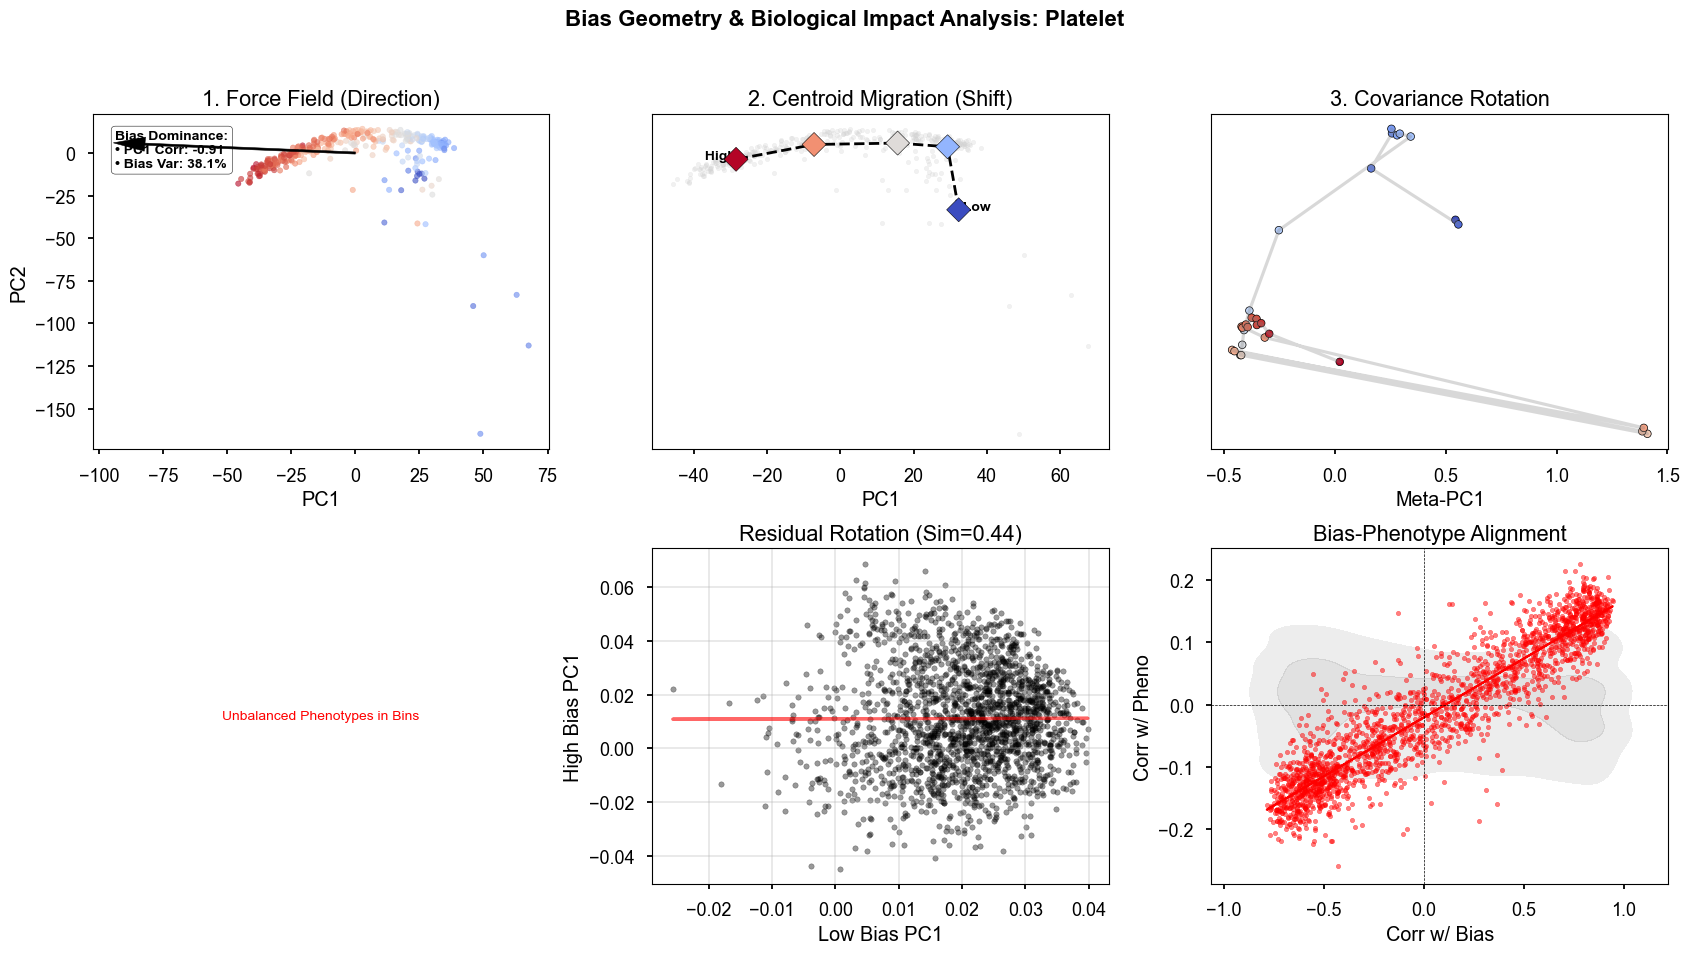

🚀 Generating Full Geometry & Impact Dashboard for: GC ...


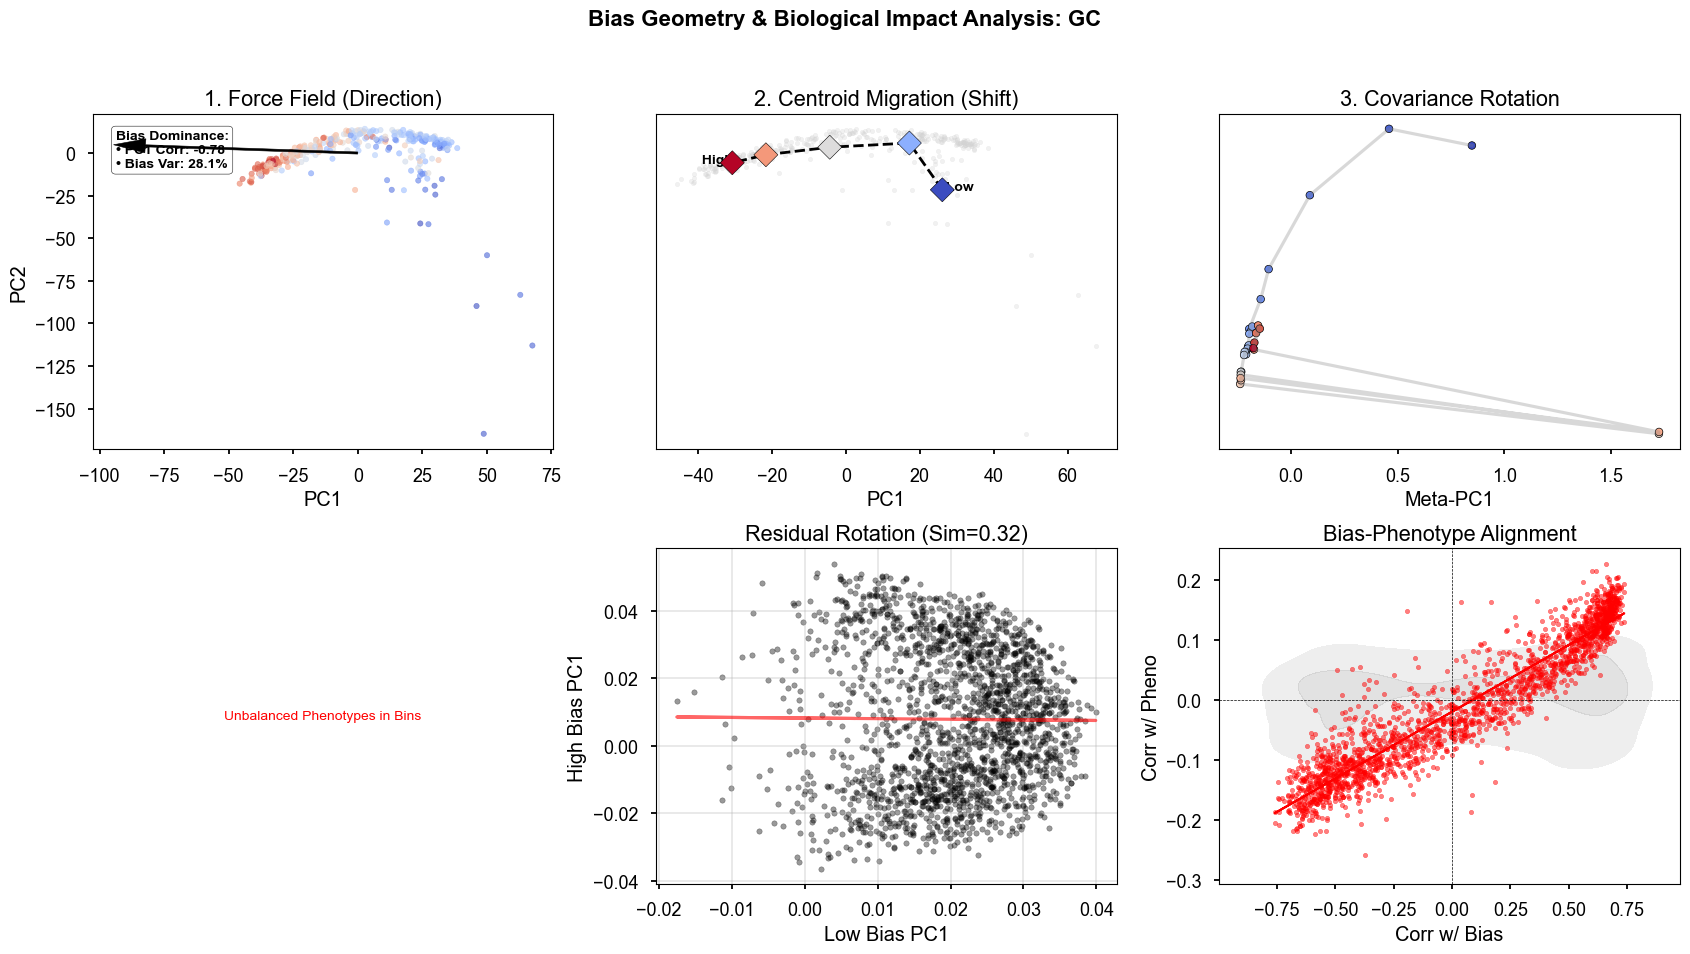

🚀 Generating Full Geometry & Impact Dashboard for: Length ...


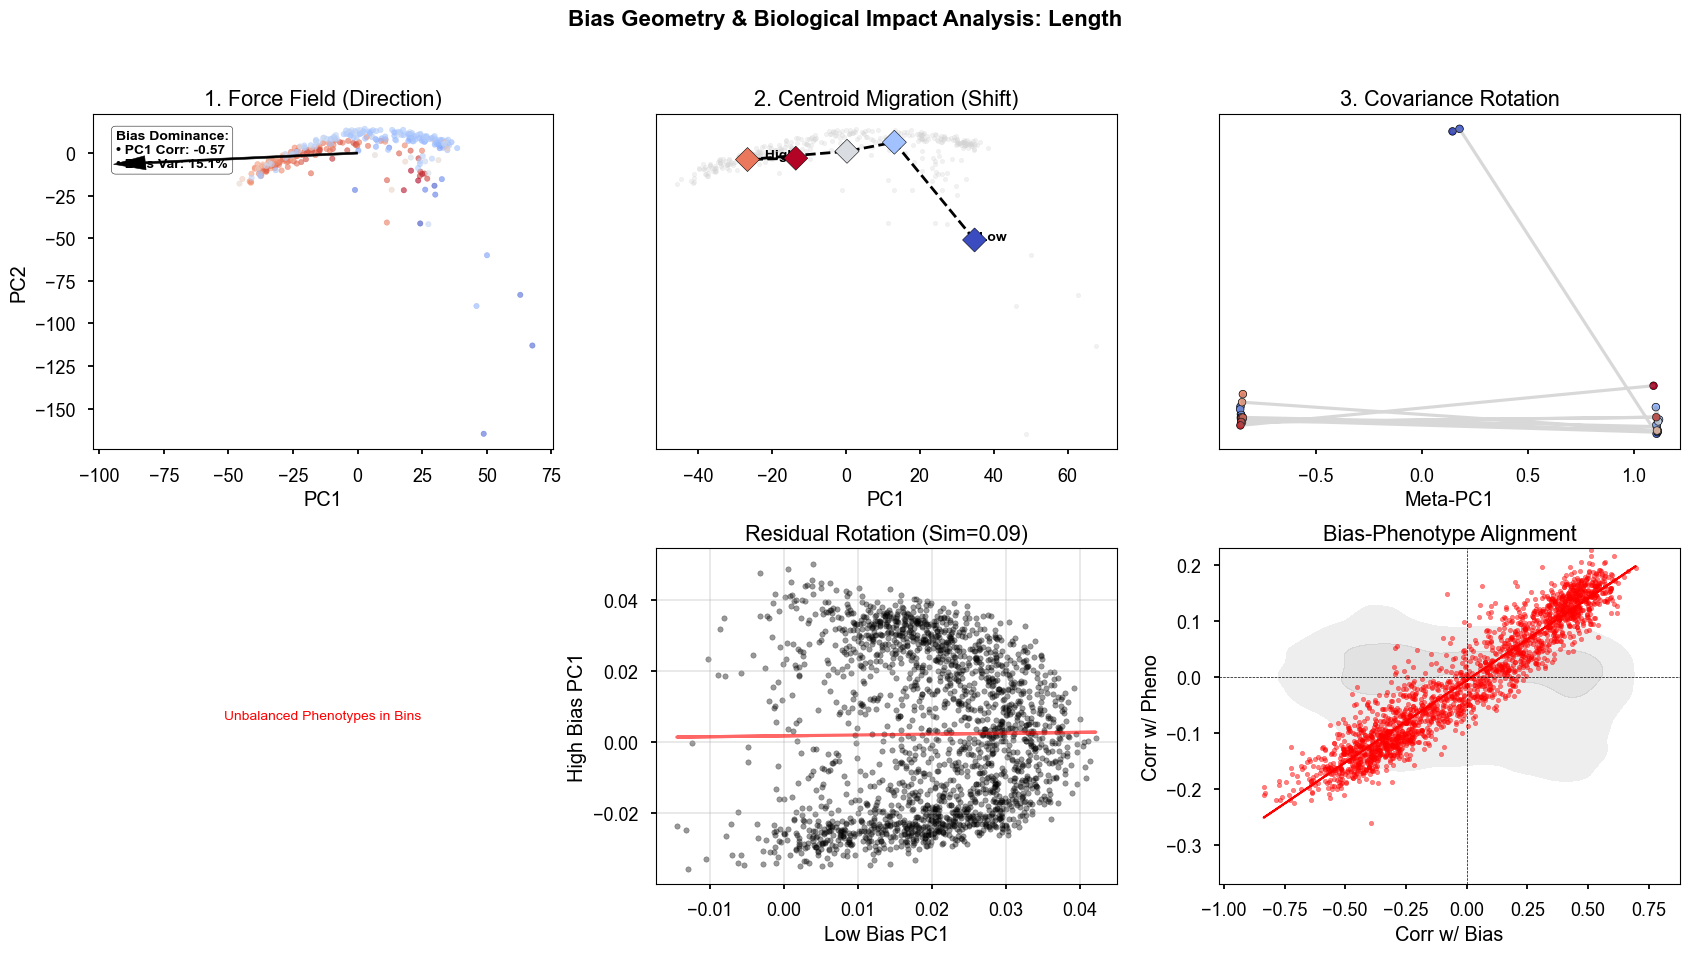

In [4]:
an = CfRNARigorousGeometry(adata, pheno_col='Type_Granular')
an.run_all(target_bias='platelet_score')
an.run_all(target_bias='gc_bias_score')
an.run_all(target_bias='len_bias_score')

### RPM subsets


 Processing: RPMseq10
🧬 Selecting 2000 stable genes (Detection > 50% & High Mean)...
   -> Final Gene Set Size: 2000
🚀 Generating Full Geometry & Impact Dashboard for: Platelet ...


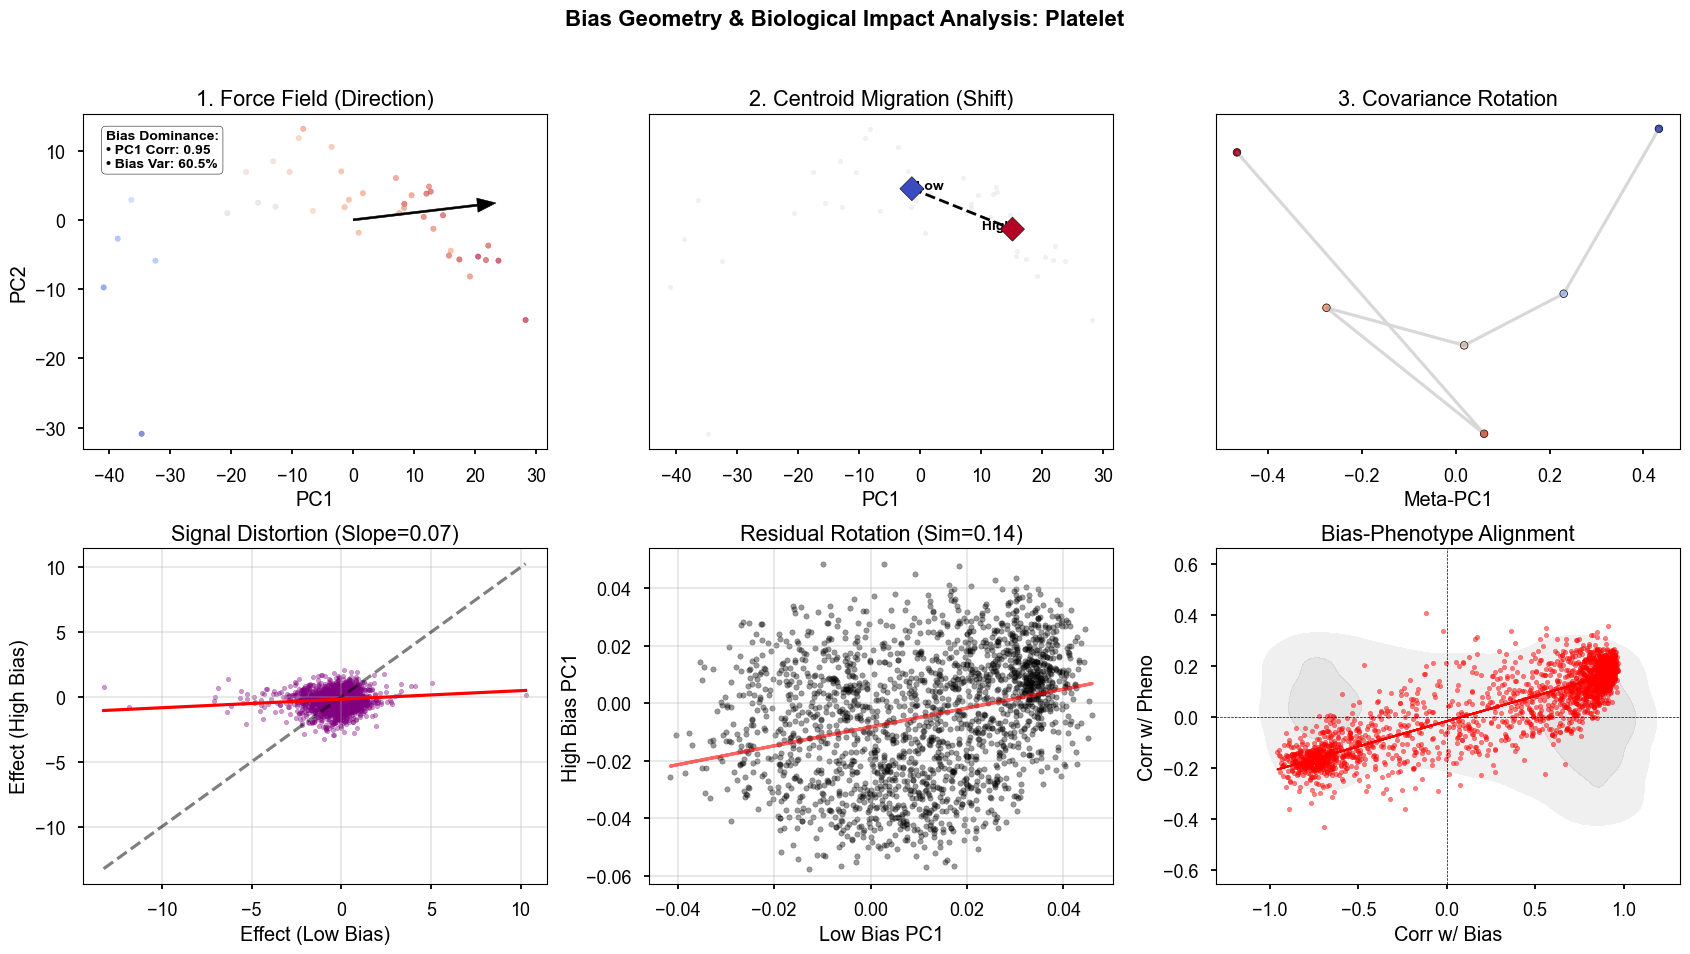

🚀 Generating Full Geometry & Impact Dashboard for: GC ...


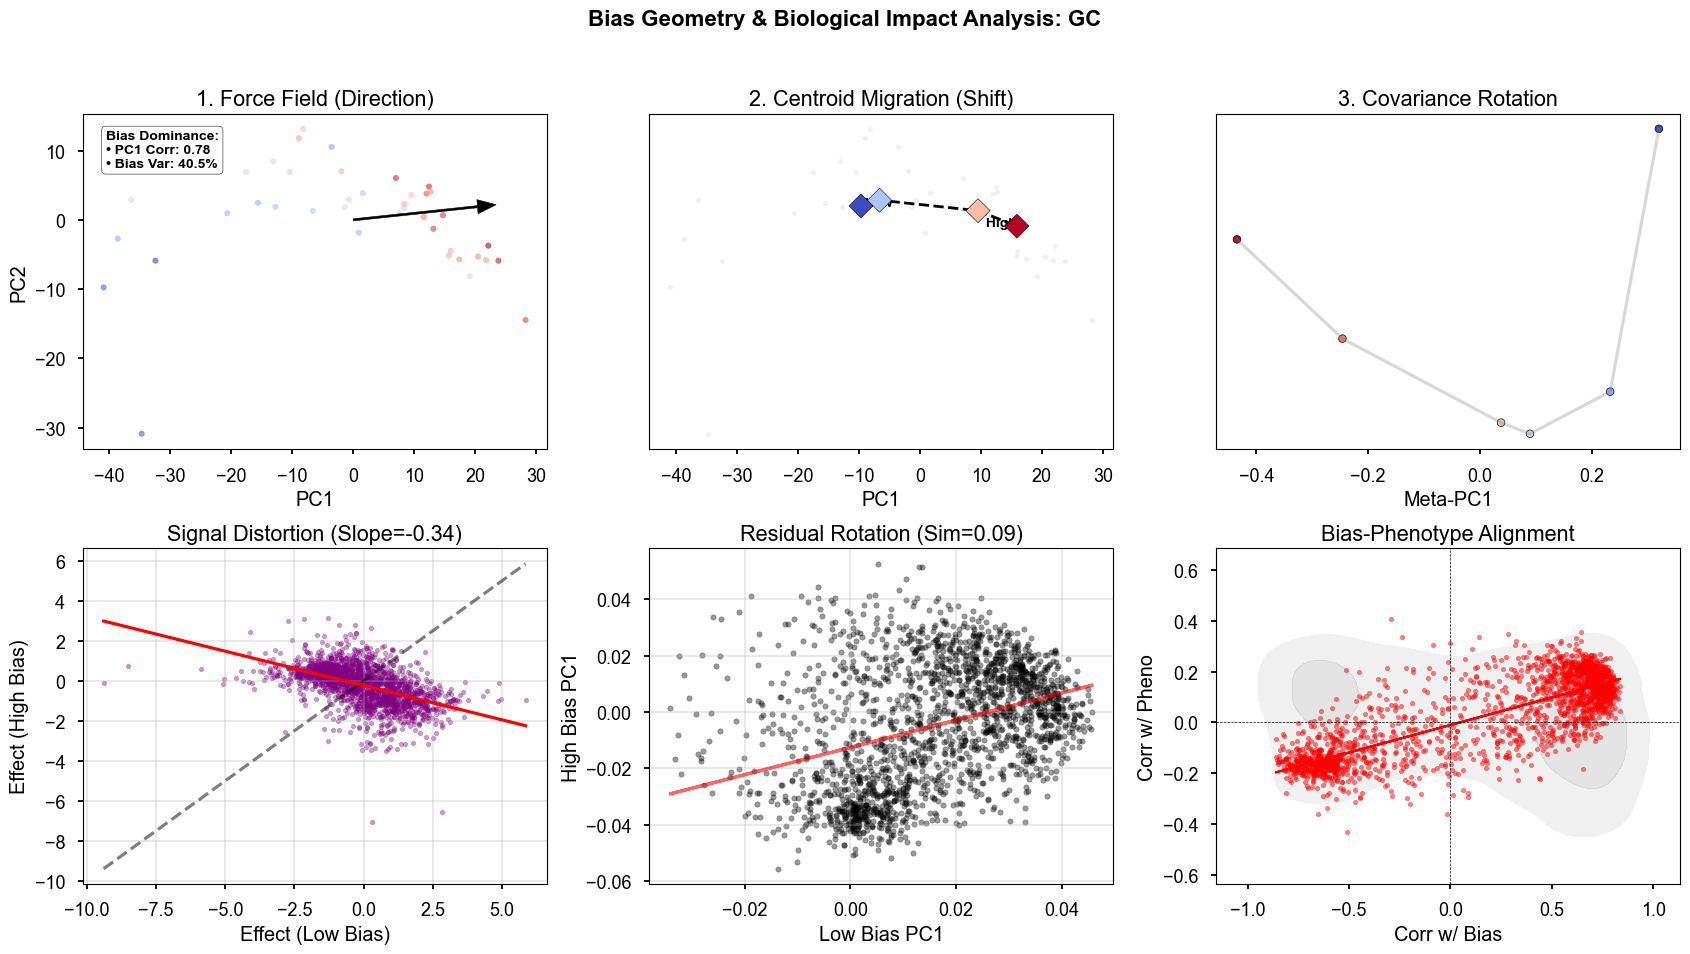

🚀 Generating Full Geometry & Impact Dashboard for: Length ...


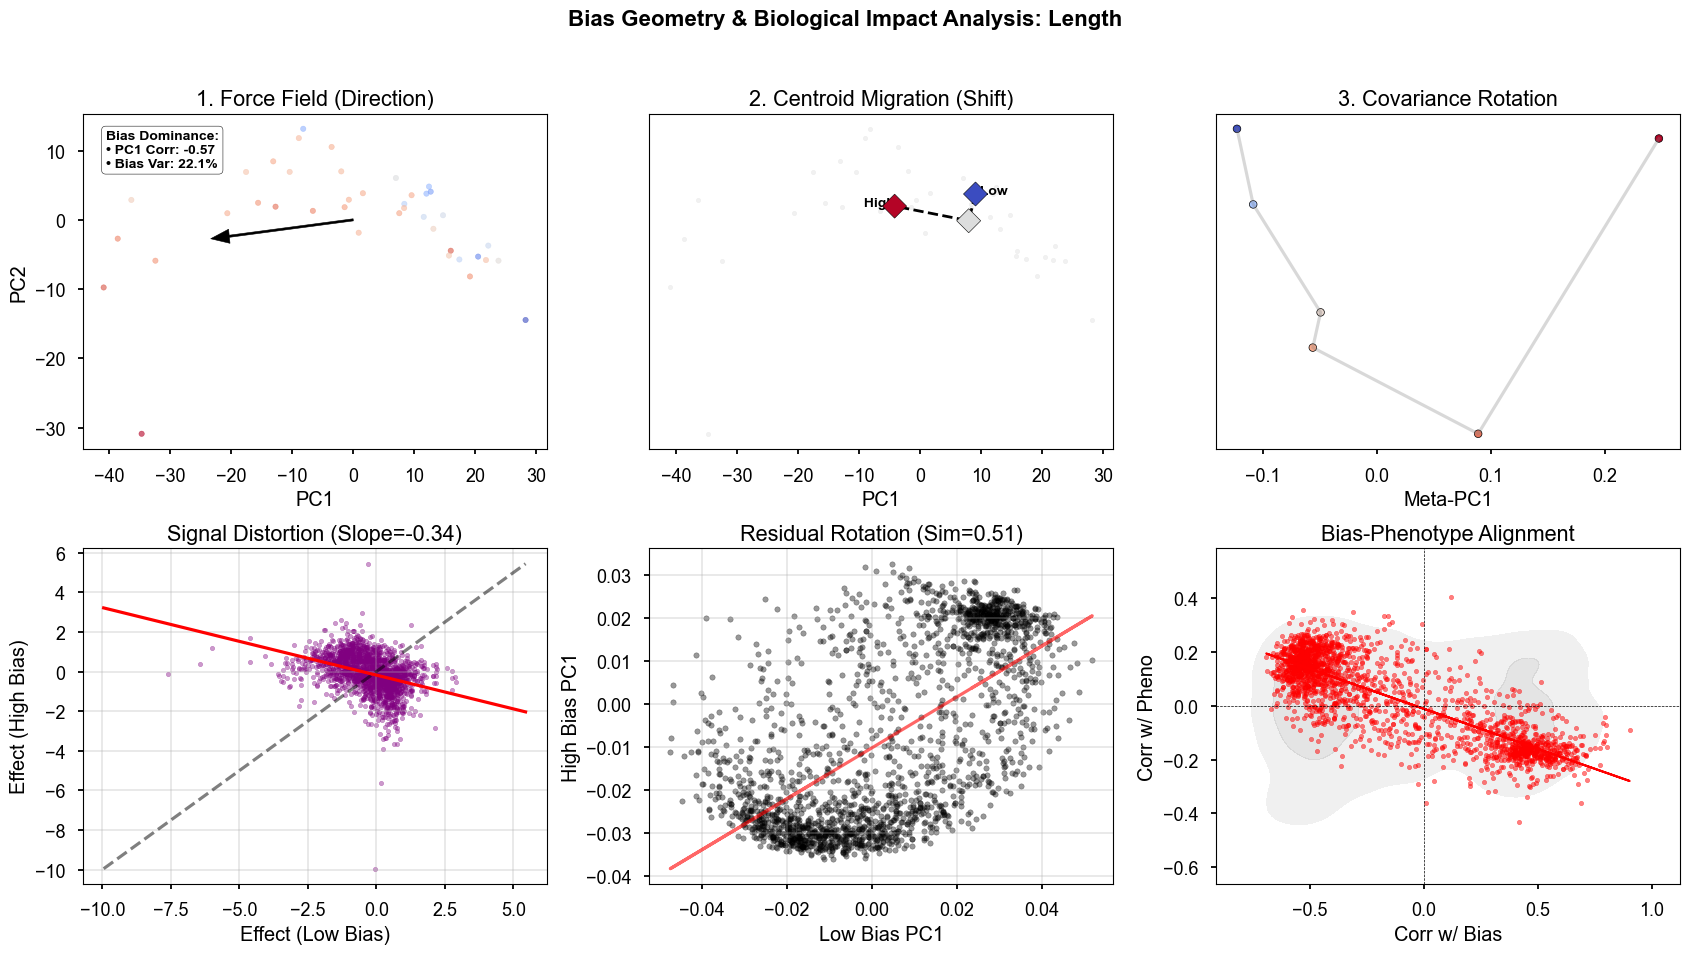

--- Finished Analysis for RPMseq10 ---

 Processing: RPMseq12
🧬 Selecting 2000 stable genes (Detection > 50% & High Mean)...
   -> Final Gene Set Size: 2000
🚀 Generating Full Geometry & Impact Dashboard for: Platelet ...


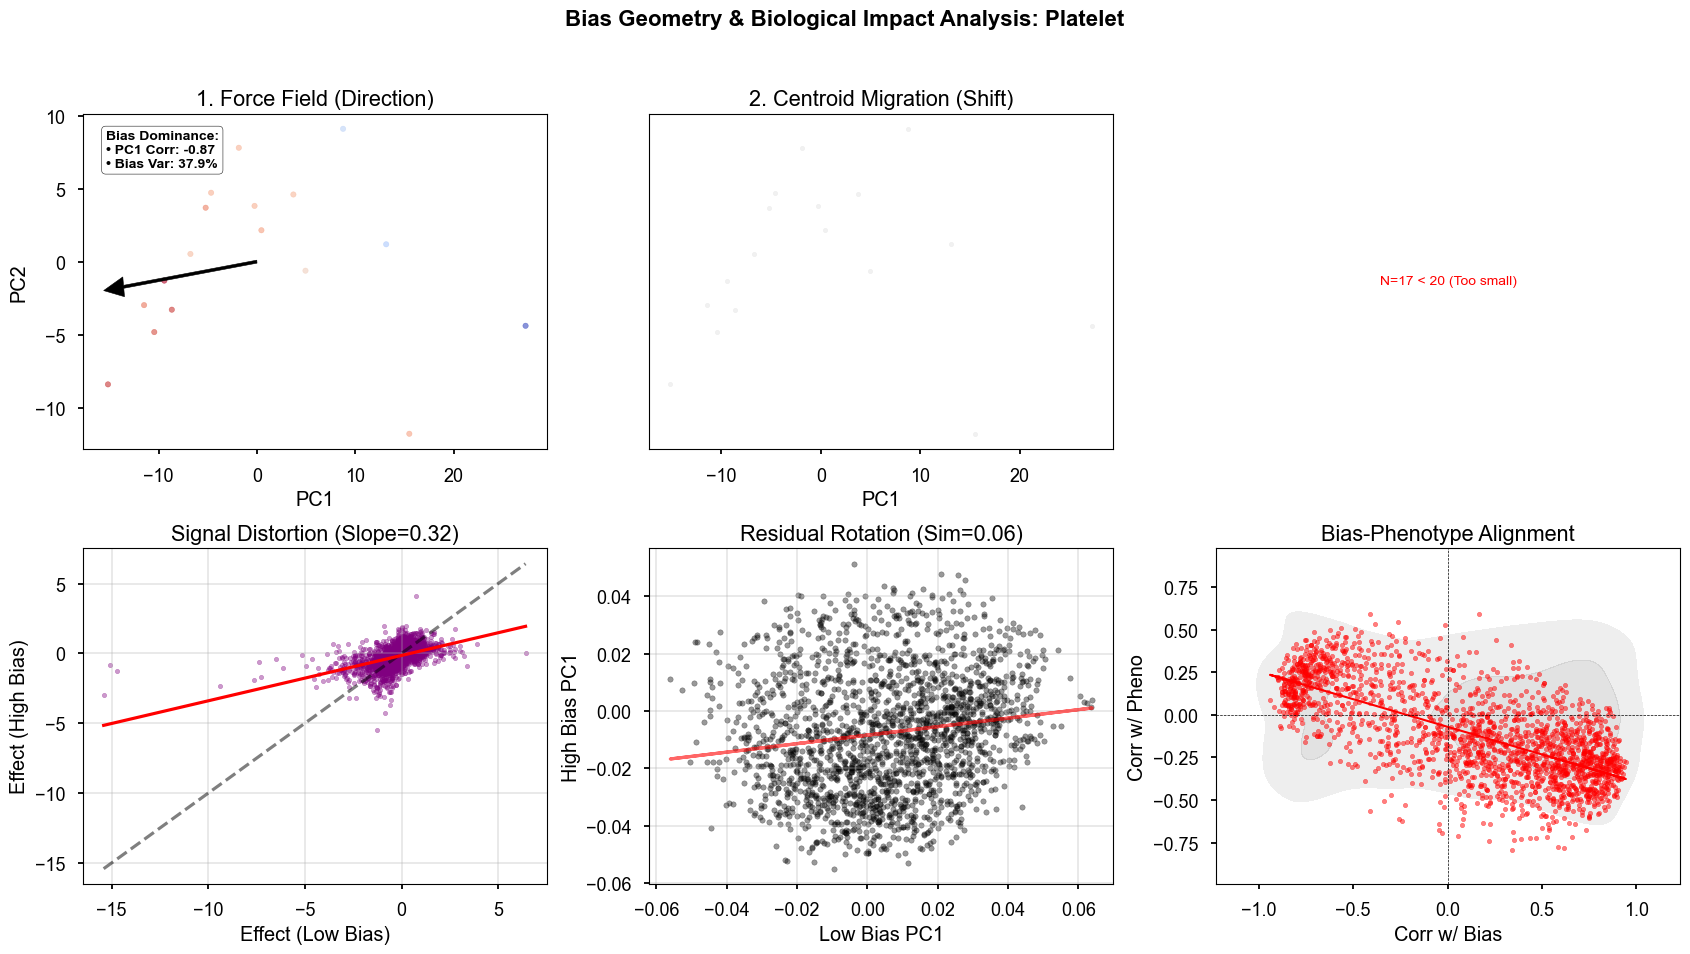

🚀 Generating Full Geometry & Impact Dashboard for: GC ...


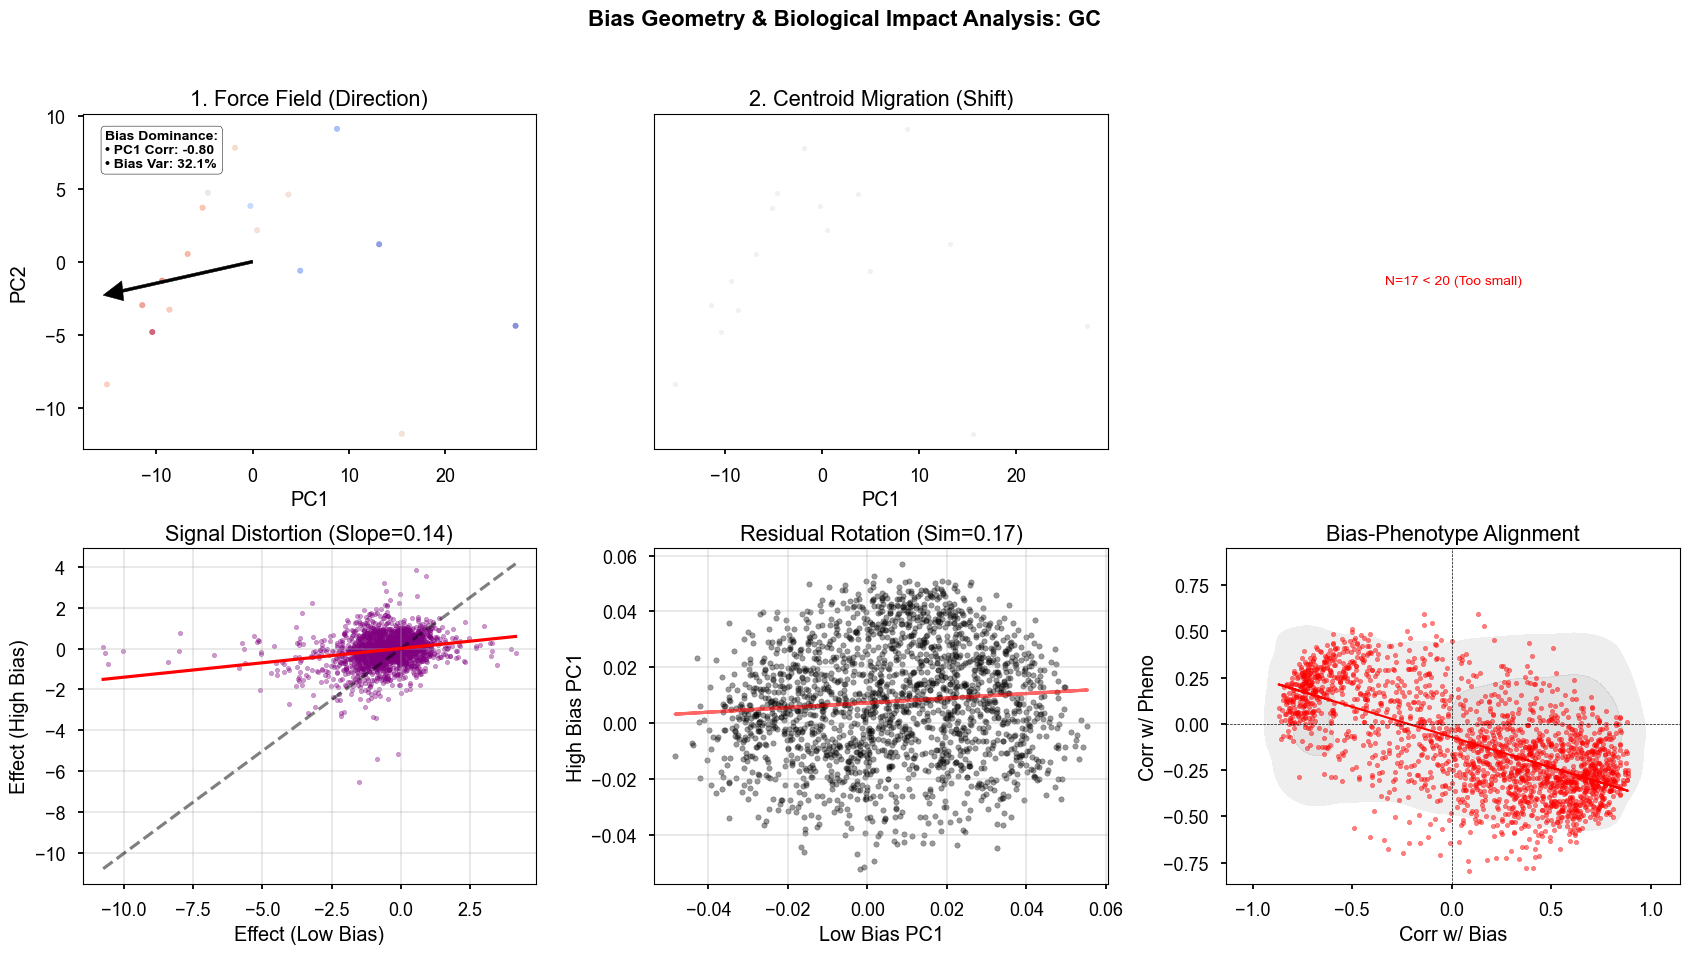

🚀 Generating Full Geometry & Impact Dashboard for: Length ...


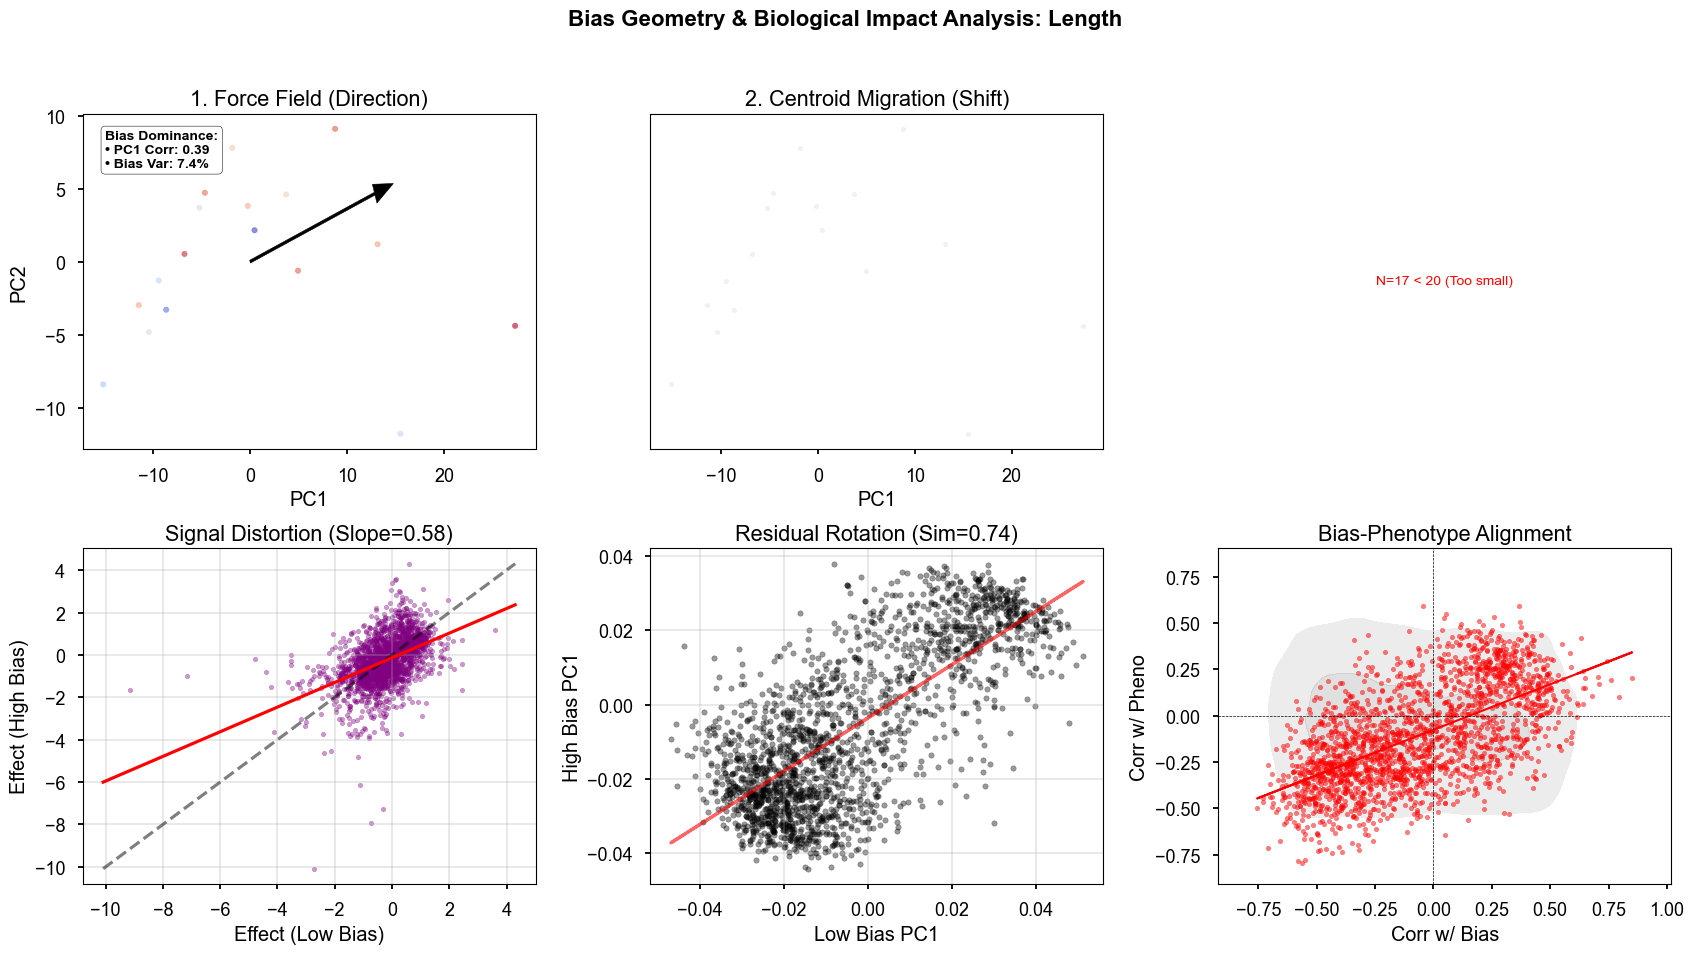

--- Finished Analysis for RPMseq12 ---

 Processing: RPMseq13
🧬 Selecting 2000 stable genes (Detection > 50% & High Mean)...
   -> Final Gene Set Size: 2000
🚀 Generating Full Geometry & Impact Dashboard for: Platelet ...


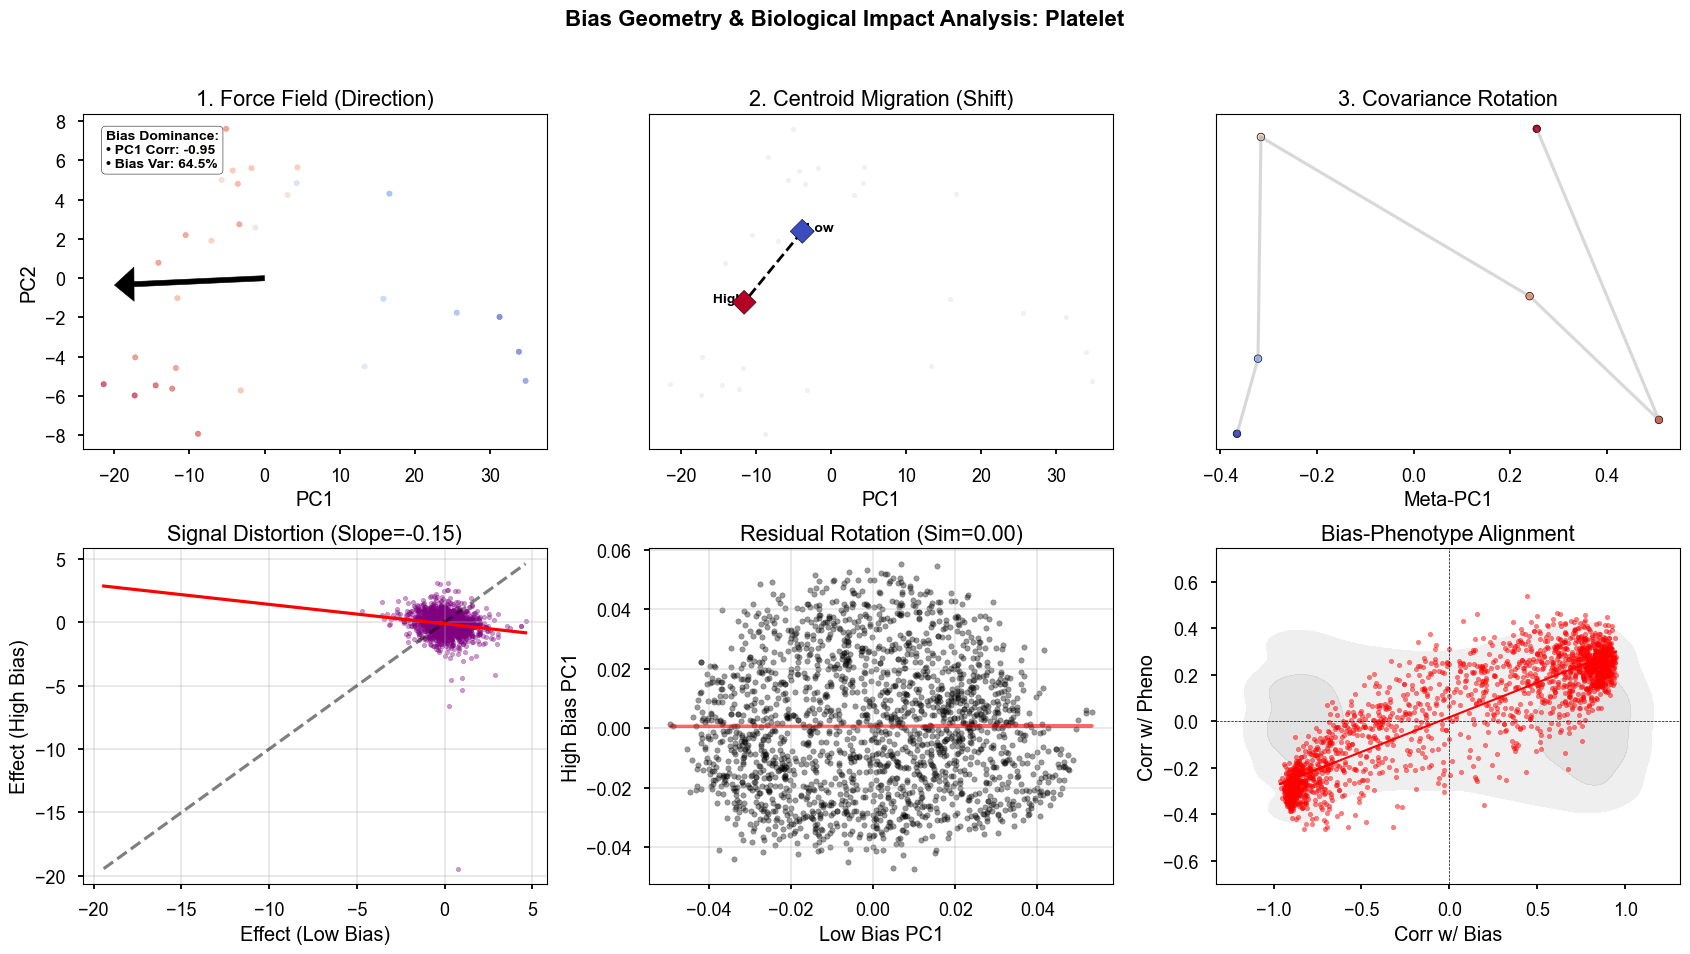

🚀 Generating Full Geometry & Impact Dashboard for: GC ...


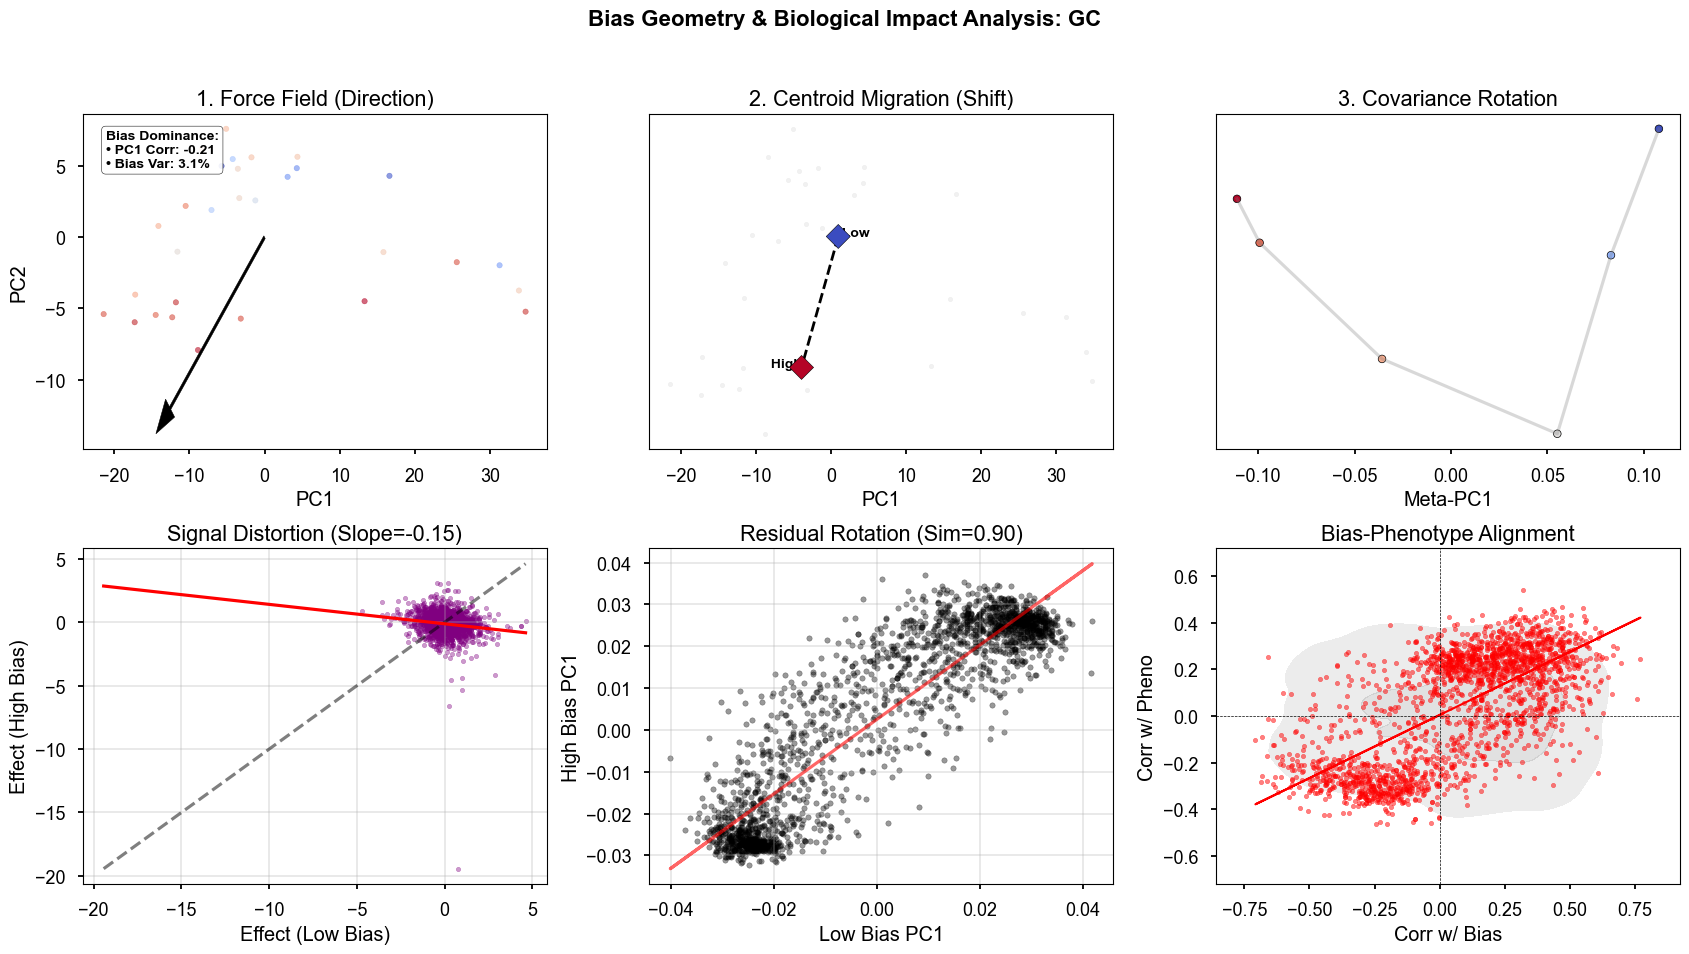

🚀 Generating Full Geometry & Impact Dashboard for: Length ...


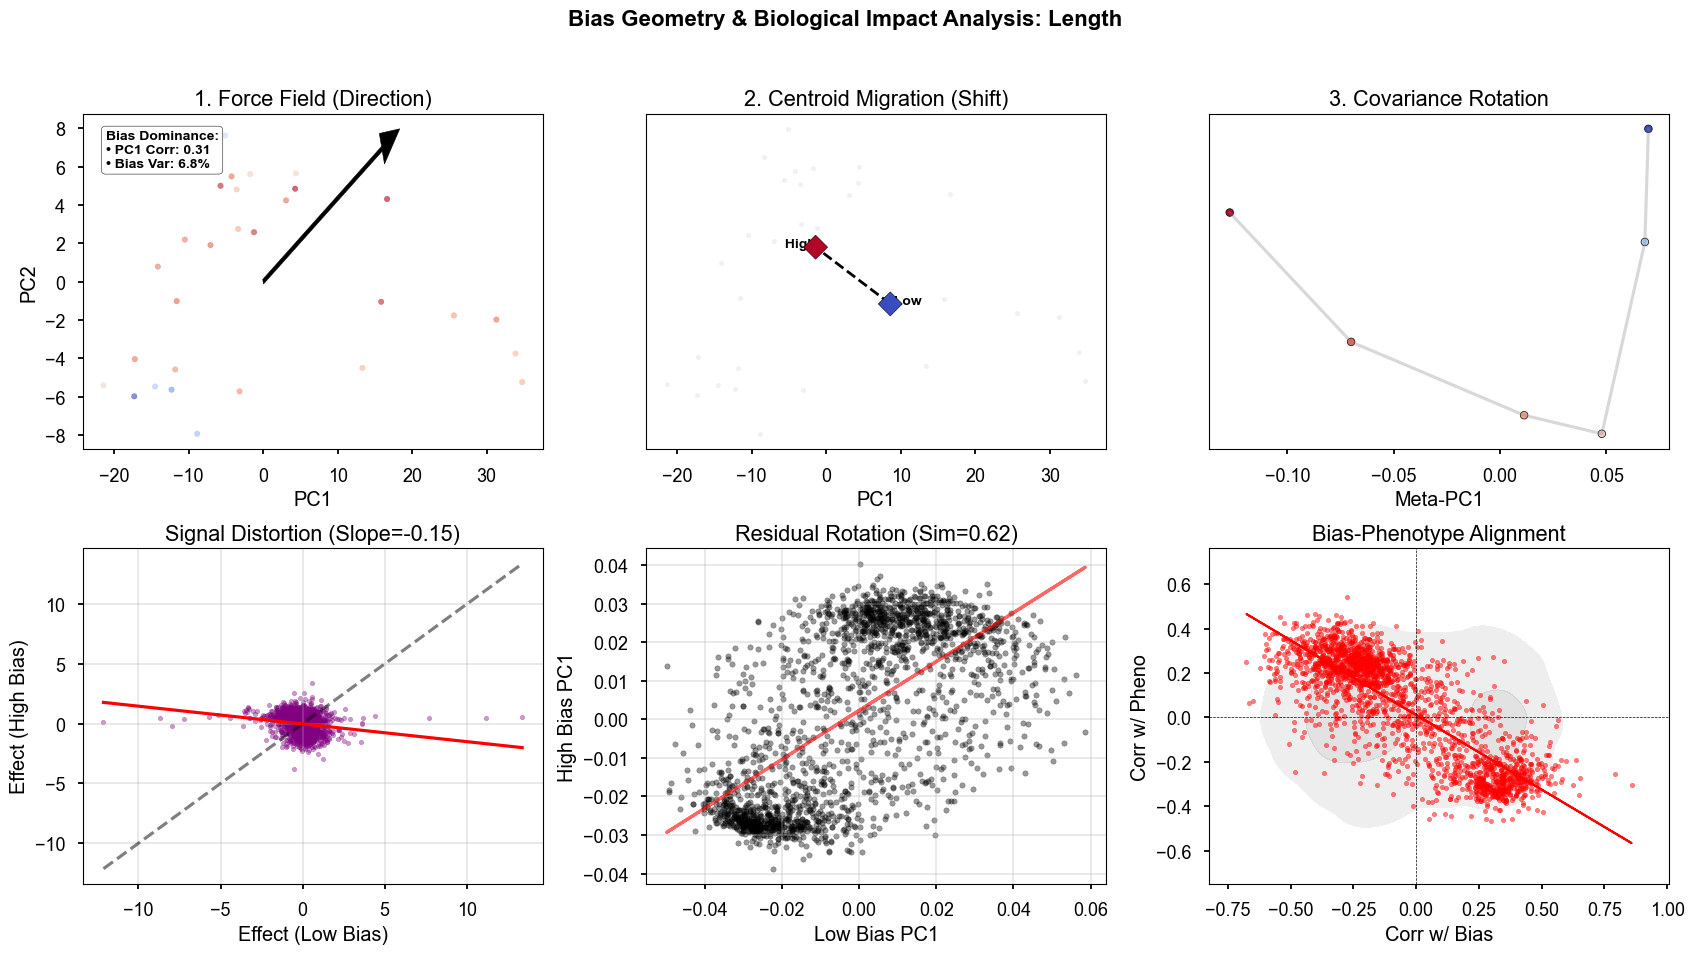

--- Finished Analysis for RPMseq13 ---

 Processing: RPMseq14
🧬 Selecting 2000 stable genes (Detection > 50% & High Mean)...
   -> Final Gene Set Size: 2000
🚀 Generating Full Geometry & Impact Dashboard for: Platelet ...


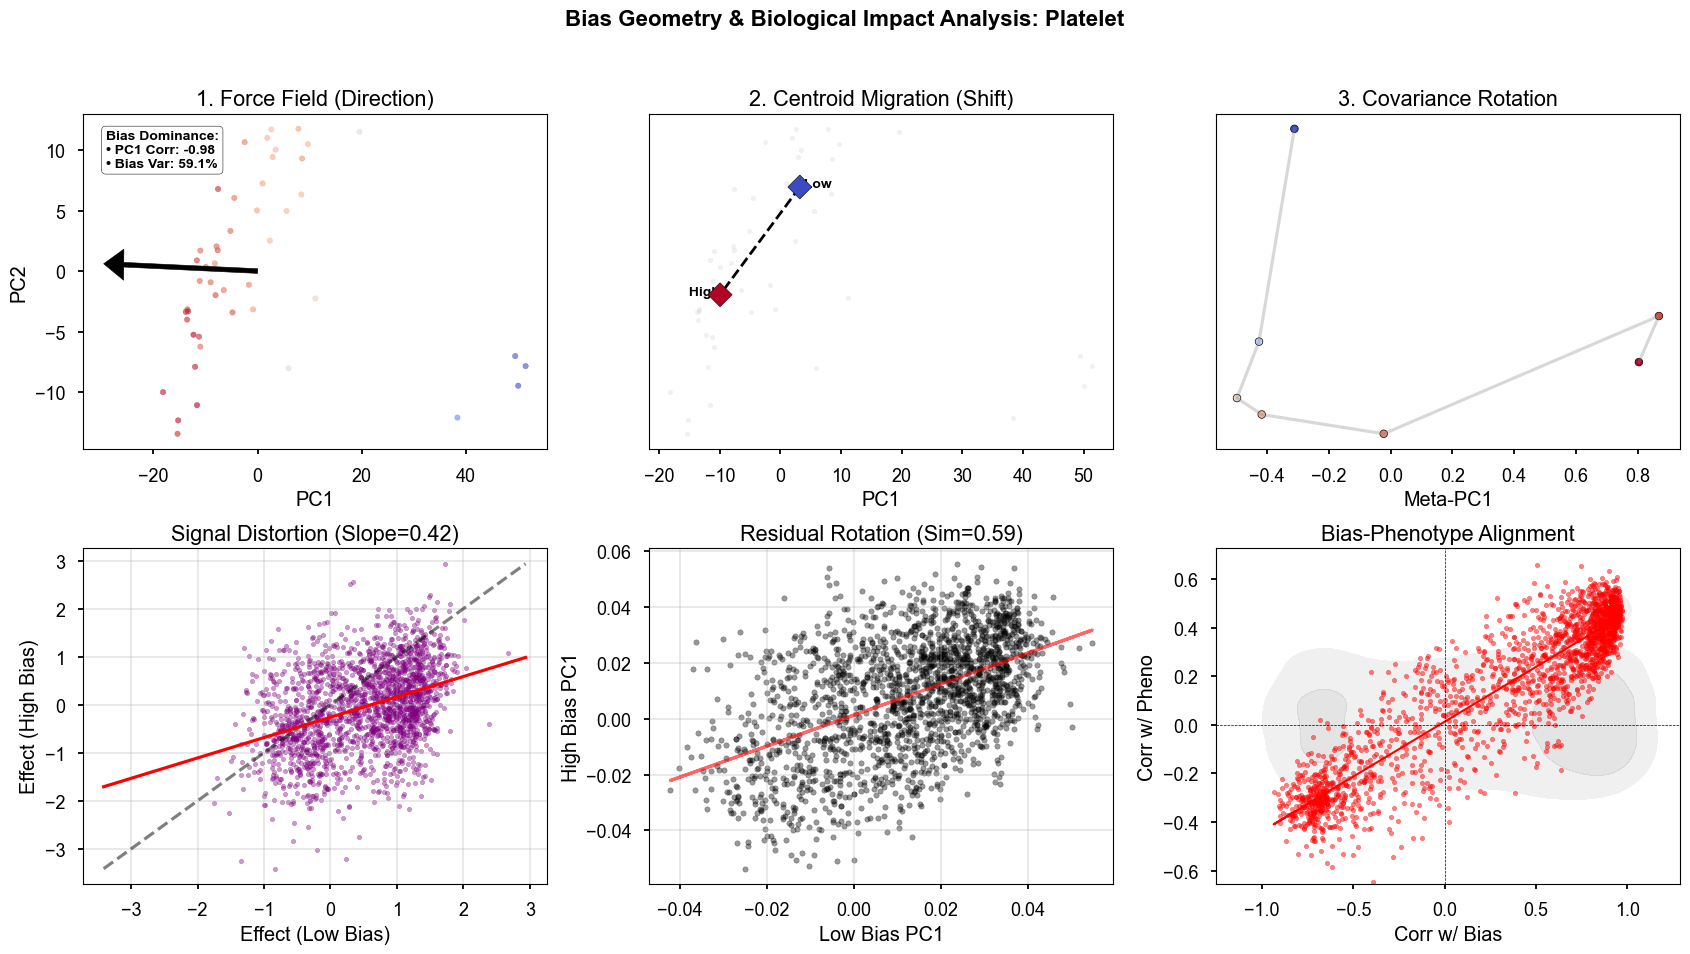

🚀 Generating Full Geometry & Impact Dashboard for: GC ...


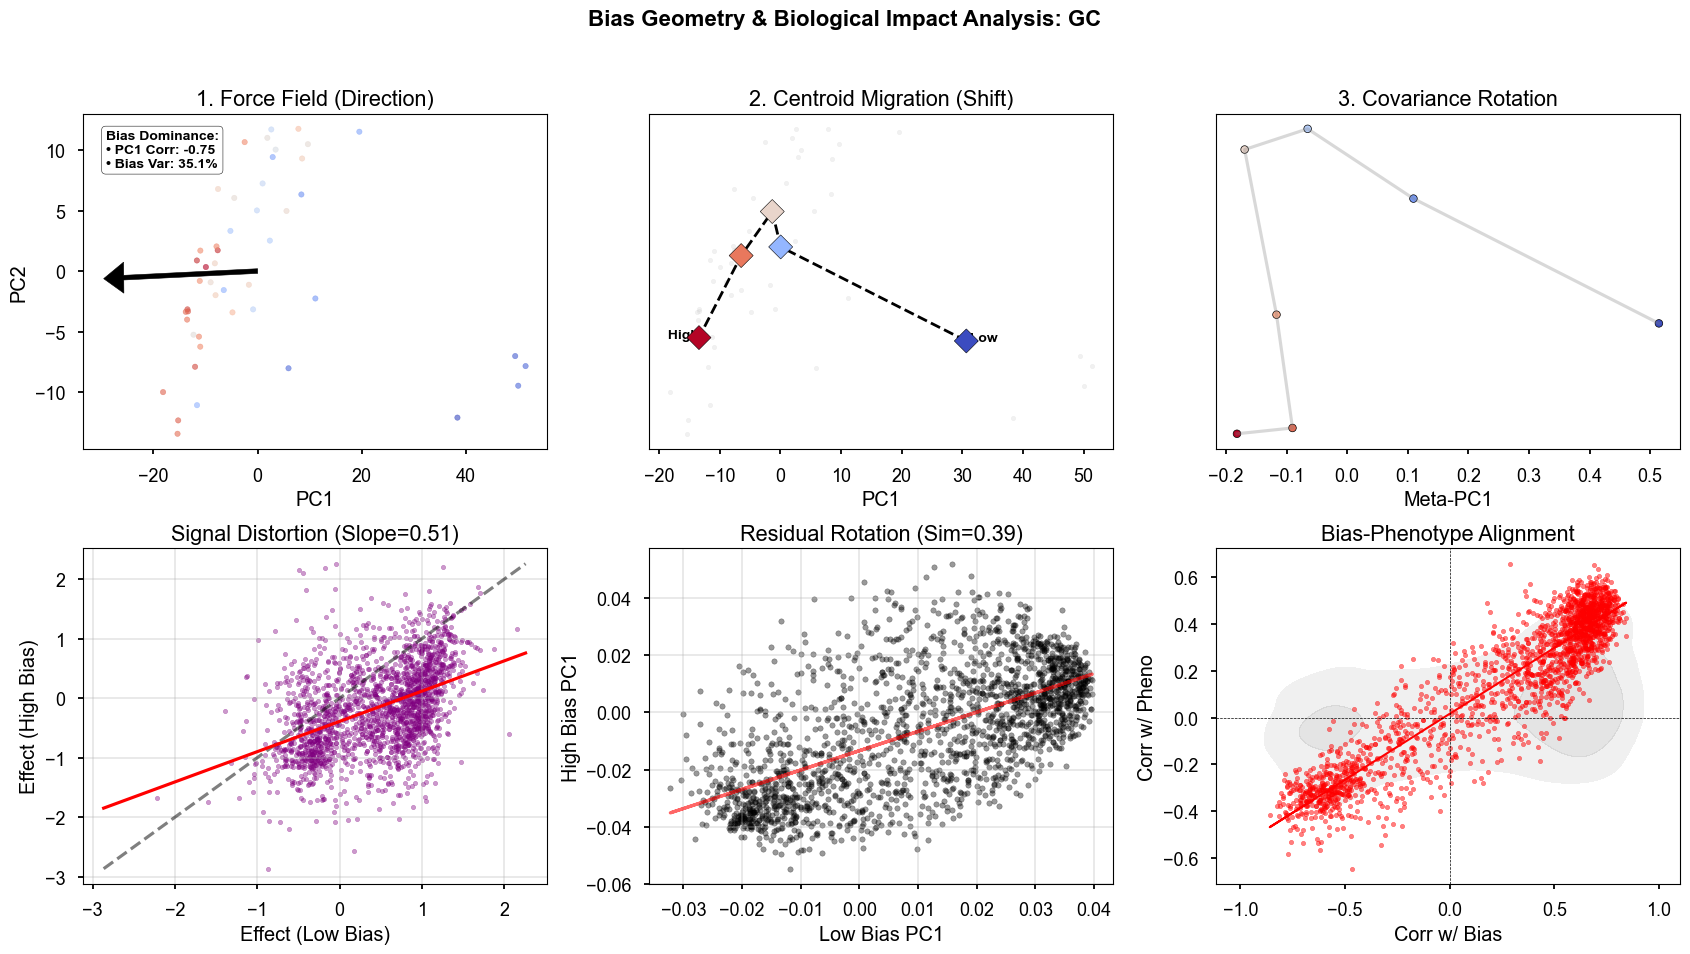

🚀 Generating Full Geometry & Impact Dashboard for: Length ...


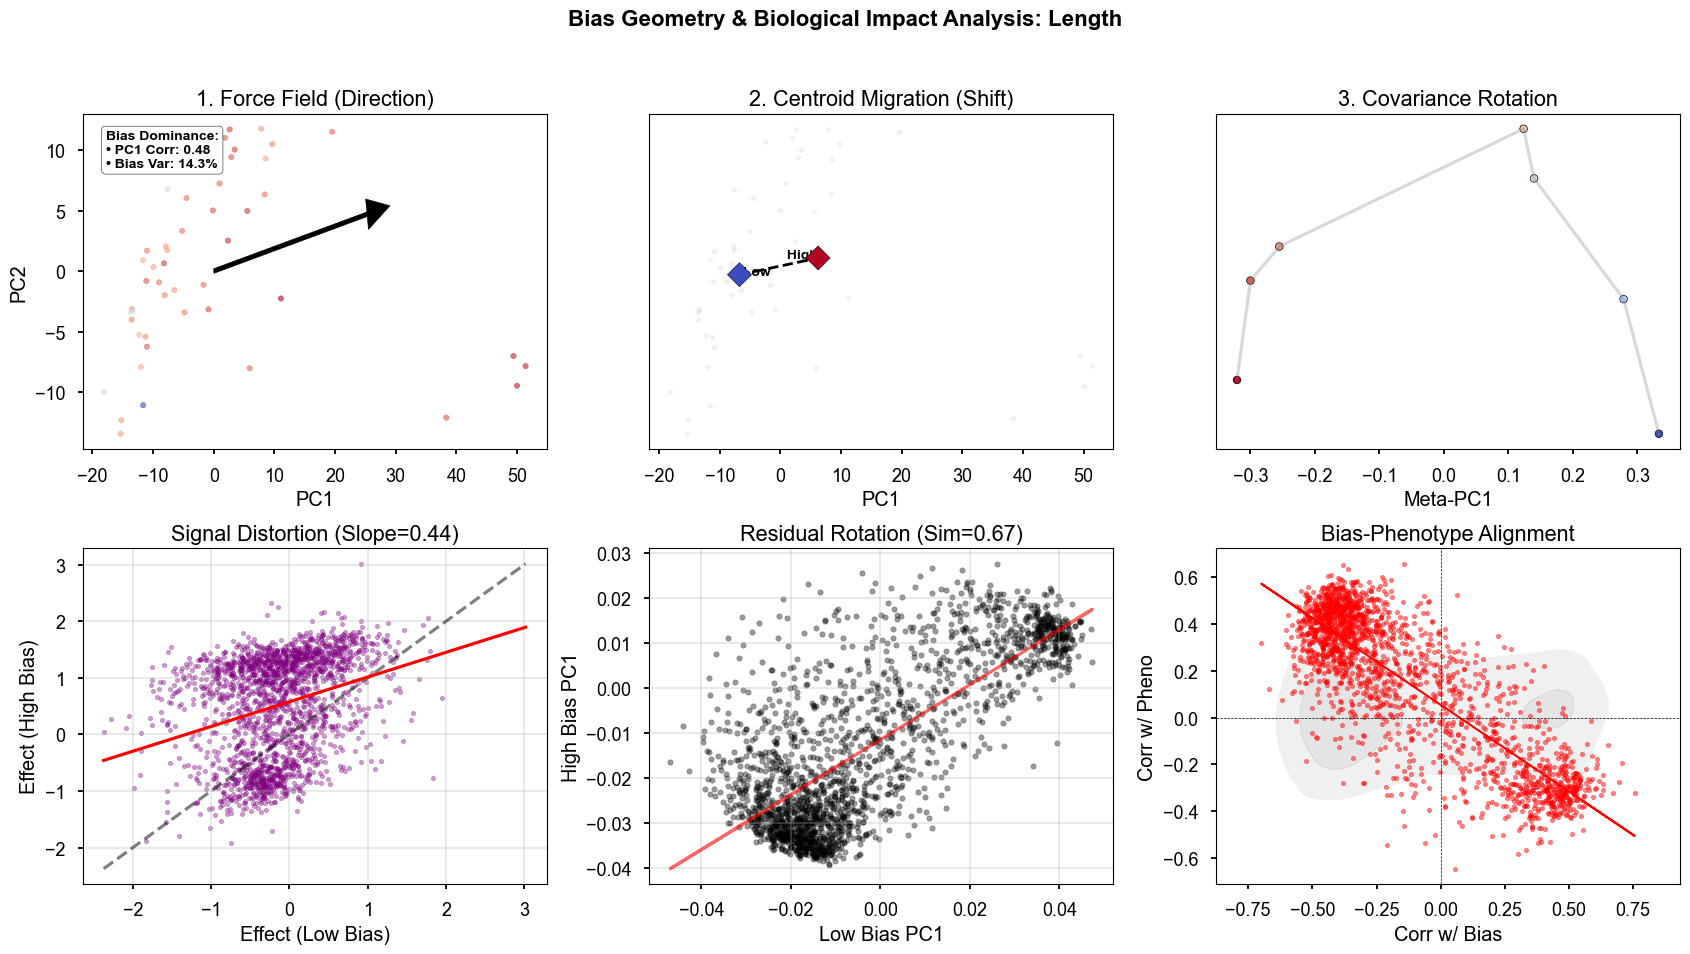

--- Finished Analysis for RPMseq14 ---

 Processing: RPMseq15
[RPMseq15] Removing samples with total counts < 441162.20
🧬 Selecting 2000 stable genes (Detection > 50% & High Mean)...
   -> Final Gene Set Size: 2000
🚀 Generating Full Geometry & Impact Dashboard for: Platelet ...


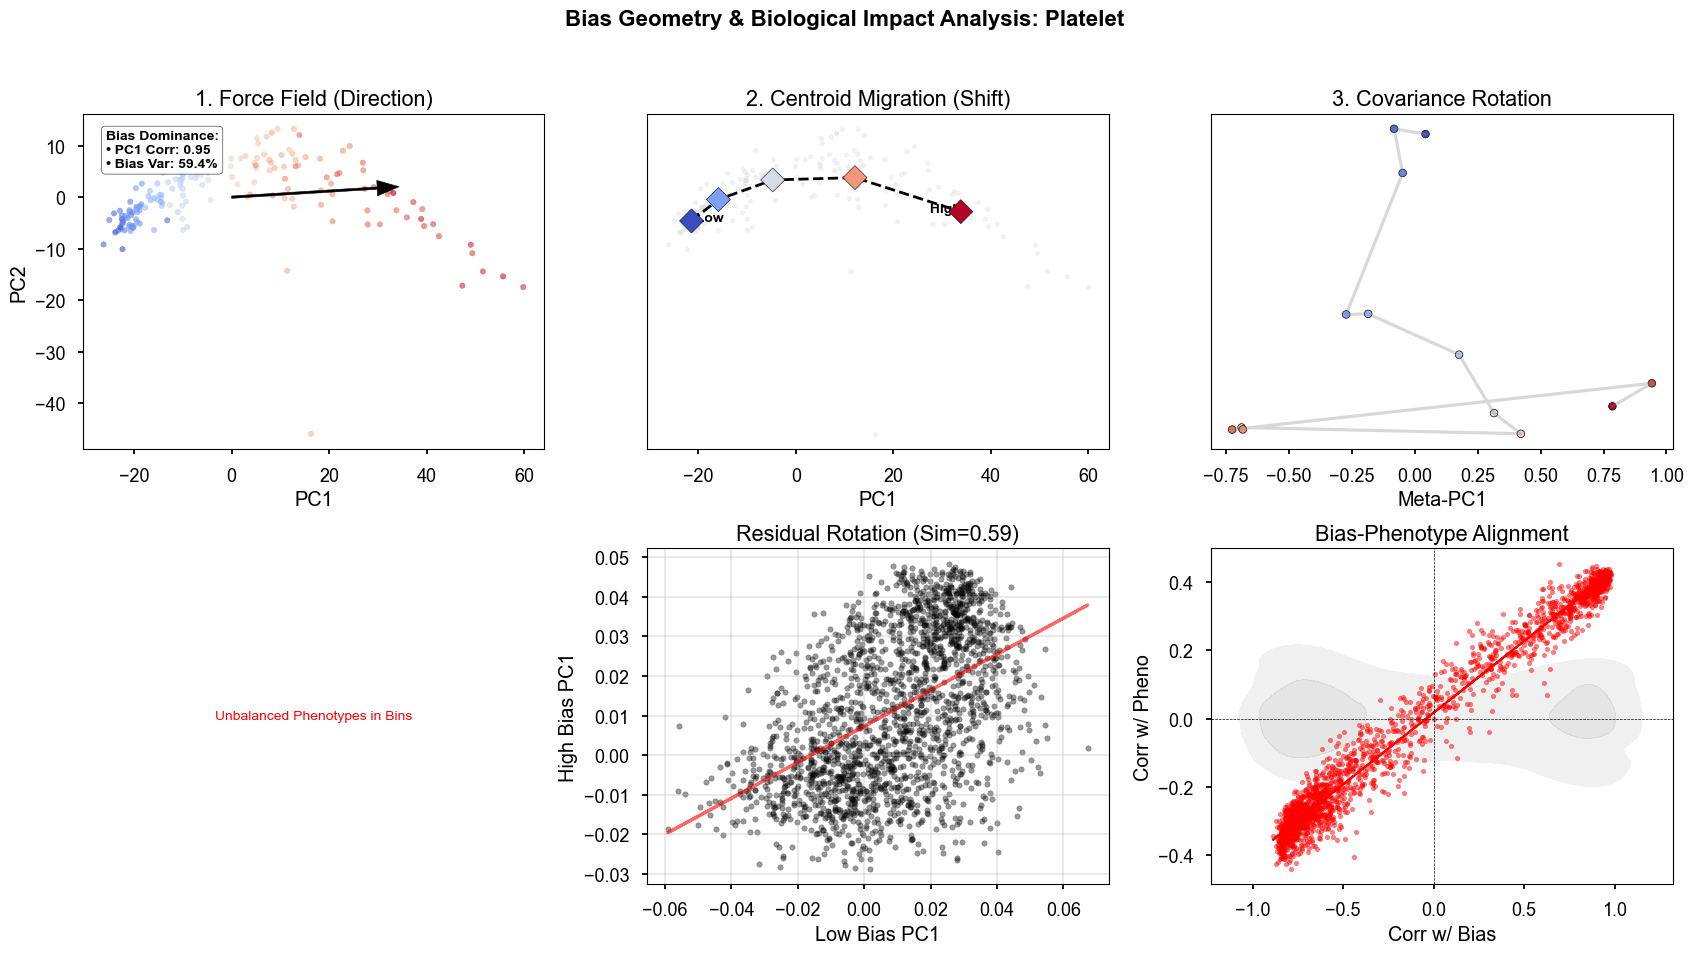

🚀 Generating Full Geometry & Impact Dashboard for: GC ...


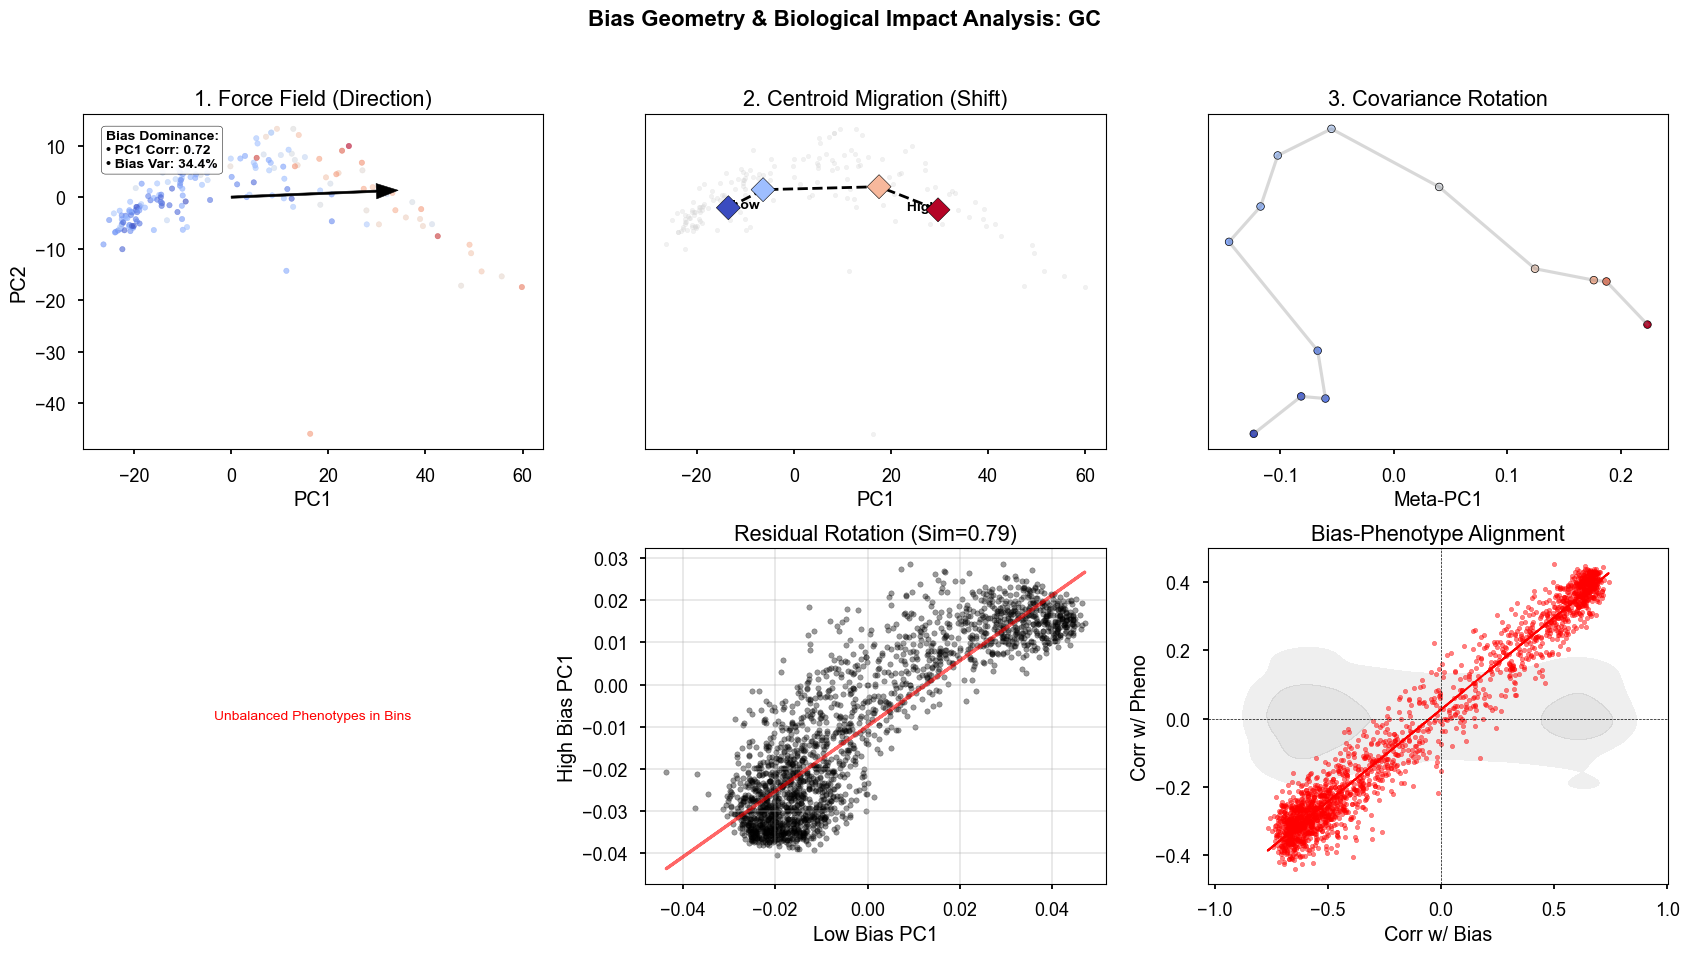

🚀 Generating Full Geometry & Impact Dashboard for: Length ...


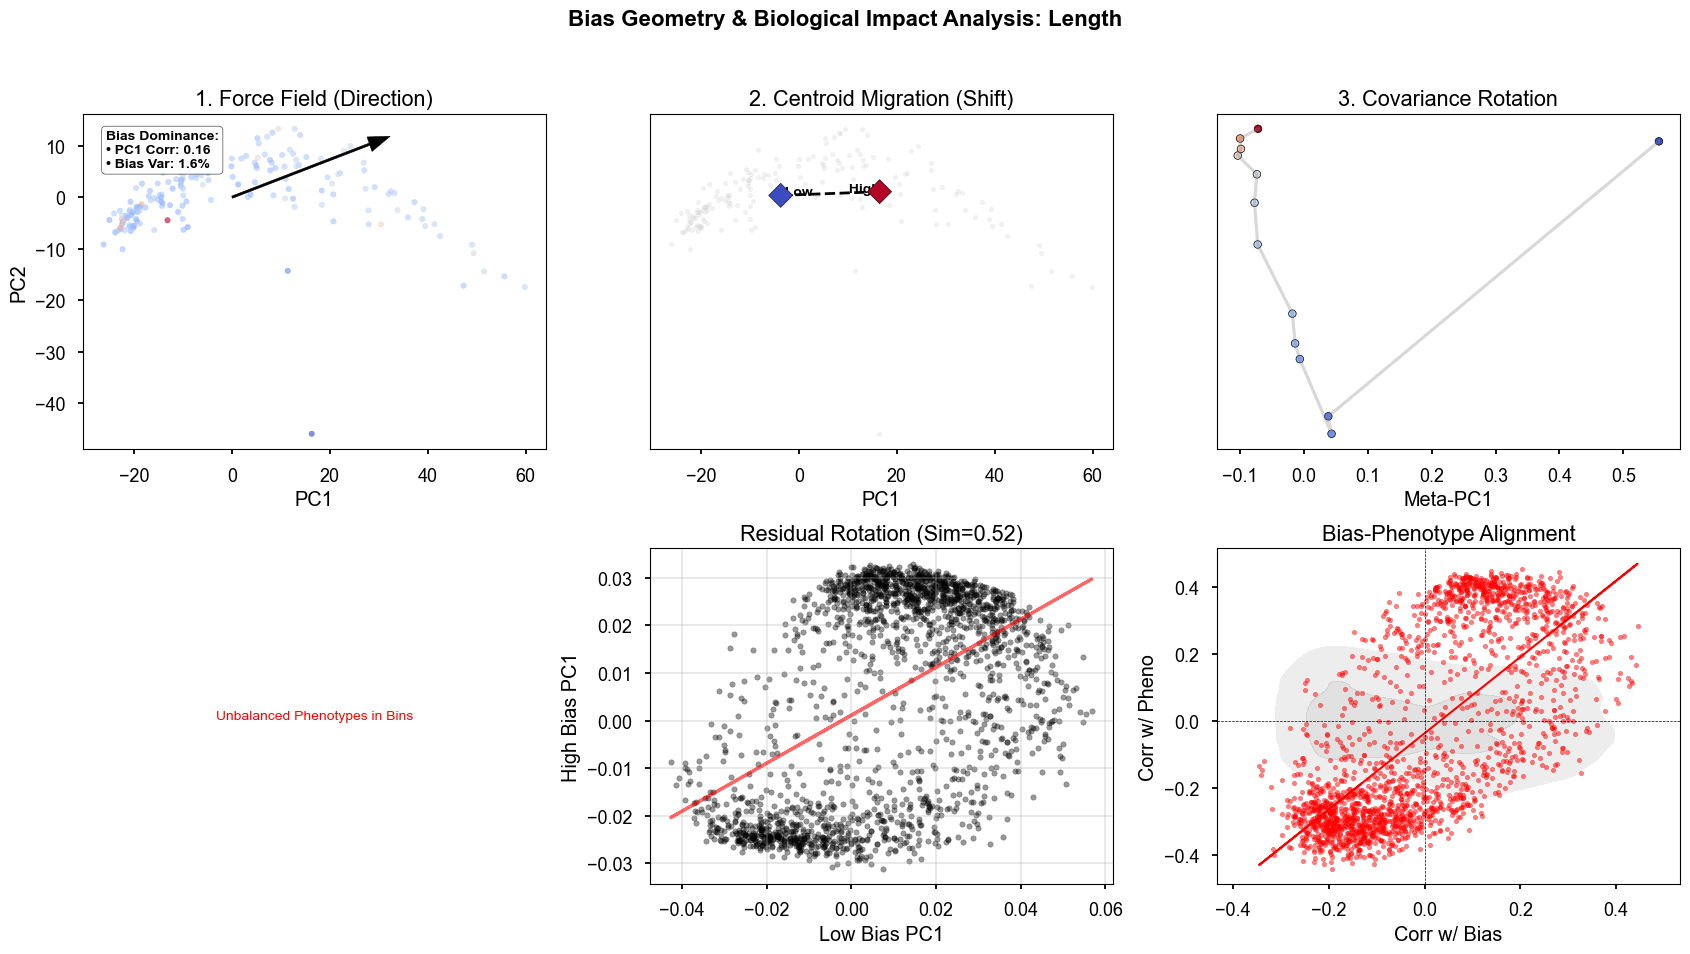

--- Finished Analysis for RPMseq15 ---


In [8]:
seq_ids = ['RPMseq10', 'RPMseq12', 'RPMseq13', 'RPMseq14', 'RPMseq15']

for sid in seq_ids:
    print(f"\n{'='*30}\n Processing: {sid}\n{'='*30}")
    adata_sub = adata[adata.obs.Seq_ID == sid].copy()
    sc.pp.filter_genes(adata_sub, min_cells=1)
    if sid == 'RPMseq15':
        temp_raw_sum = adata_sub.obs['total_counts']
        cutoff = np.quantile(temp_raw_sum, 0.1)
        print(f"[{sid}] Removing samples with total counts < {cutoff:.2f}")
        adata_sub = adata_sub[temp_raw_sum >= cutoff].copy()
        if 'Responder' in adata_sub.obs.columns:
            adata_sub.obs['Responder'] = adata_sub.obs['Responder'].astype('category')

    an = CfRNARigorousGeometry(adata_sub, pheno_col='Type_Granular')
    an.run_all(target_bias='platelet_score')
    an.run_all(target_bias='gc_bias_score')
    an.run_all(target_bias='len_bias_score')

    print(f"--- Finished Analysis for {sid} ---")